In [12]:
import json
import os
def load_jsonl(file_path):
    """Load papers from a .jsonl file safely (one JSON object per line)."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f" File not found: {file_path}")
    
    papers = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line_number, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue  # skip empty lines
            try:
                paper = json.loads(line)
                papers.append(paper)
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON on line {line_number}: {e}")
                continue
    return papers


import json
import os

def load_jsonl1(file_path, limit=10000):
    """Load up to `limit` records from a .jsonl file safely."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    papers = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line_number, line in enumerate(f, start=1):
            if len(papers) >= limit:
                break
            line = line.strip()
            if not line:
                continue
            try:
                papers.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON on line {line_number}: {e}")
    return papers


In [13]:
paperswithpast = load_jsonl1("Data_to_run50000.jsonl", limit=10000)


In [14]:
paperswithpast[2]

{'author_group': ['Richard Duong',
  'Nicolaj Rux',
  'Viktor Stein',
  'Gabriele Steidl'],
 'current_papers': [{'id': 'http://arxiv.org/abs/2411.09848v2',
   'title': 'Wasserstein Gradient Flows of MMD Functionals with Distance Kernels under Sobolev Regularization',
   'arxiv_id': '2411.09848v2',
   'published': '2024-11-14T23:48:39Z',
   'categories': ['math.AP']}],
 'past_papers': [{'id': 'http://arxiv.org/abs/2108.00227v1',
   'title': 'On the Dynamical System of Principal Curves in $\\mathbb R^d$',
   'arxiv_id': '2108.00227v1',
   'published': '2021-07-31T12:19:16Z',
   'categories': ['math.DS'],
   'abstract': 'Principal curves are natural generalizations of principal lines arising as first principal components in the Principal Component Analysis. They can be characterized from a stochastic point of view as so-called self-consistent curves based on the conditional expectation and from the variational-calculus point of view as saddle points of the expected difference of a random 

In [15]:
import nltk
# Run this once if you haven't downloaded the tokenizer
# nltk.download('punkt')

def extract_first_last(text):
    if not text or len(text.strip()) == 0:
        return "", ""
    
    # This handles abbreviations like "e.g." correctly
    sentences = nltk.sent_tokenize(text)
    
    first_sentence = sentences[0]
    # If the abstract is only one sentence, first and last are the same
    last_sentence = sentences[-1] 
    
    return first_sentence, last_sentence

# Example usage
abstract = "The group studied GNNs for chemistry. They applied Method X to Dataset Y. Finally, our results show a 10% improvement."
first, last = extract_first_last(abstract)

print(f"First: {first}")
print(f"Last: {last}")

First: The group studied GNNs for chemistry.
Last: Finally, our results show a 10% improvement.


In [16]:
all_cur = []

for rec in paperswithpast:
    rec_w = []
    for cp in rec.get("current_papers", []) or []:
        abstract = cp.get("abstract", "") or ""
        first_sentence, last_sentence = extract_first_last(abstract)
        text = (
            (cp.get("title", "") or "").strip() + " " +
            first_sentence + " " +
            last_sentence
        ).strip()

        if text:  # only keep non-empty
            rec_w.append(text)

    all_cur.append(rec_w)


In [44]:
def flatten_2024_corpus(papers):
    """
    papers: list of dicts with keys: author_group, current_papers (list)
    returns: list of paper dicts: {"title":..., "authors":[...], "categories":[...]}
    """
    flat = []
    for rec in papers:
        authors = rec.get("author_group", []) or []
        for cp in rec.get("current_papers", []) or []:
            flat.append({
                "title": cp.get("title", ""),
                "authors": authors,
                "categories": cp.get("categories", []) or []
            })
    return flat

papers_2024 = flatten_2024_corpus(paperswithpast)
all_titles_2024 = [p["title"] for p in papers_2024]


In [18]:
def pool_by_categories(papers_2024, allowed_categories):
    allowed = set(allowed_categories)
    return [p["title"] for p in papers_2024 if set(p["categories"]) & allowed]

def allowed_categories_from_true_title(true_title, papers_2024):
    for p in papers_2024:
        if p["title"] == true_title:
            return p.get("categories", []) or []
    return []

def category_pool_with_fallback(
    papers_2024,
    allowed_categories,
    fallback_titles,
    min_size=2
):
    pool = pool_by_categories(papers_2024, allowed_categories)
    if len(pool) < min_size:
        return fallback_titles
    return pool


In [19]:

with open("current_titles.json", "r") as f:
    current = json.load(f)



len(current)

15000

In [20]:
from collections import defaultdict

def build_category_to_titles(papers_2024):
    cat2titles = defaultdict(list)
    for p in papers_2024:
        title = p["title"]
        cats = p.get("categories", []) or []
        for c in cats:
            cat2titles[c].append(title)
    return cat2titles


In [21]:
current[:2]

['On Long Orbit Empty Value (LOEV) principle',
 'Asymptotics of commuting $\\ell$-tuples in symmetric groups and log-concavity']

In [195]:

# with open("predictions/2024_run_all_results_titleCOT.json", "r") as f:
#     preds1 = json.load(f)

# with open("predictions/2024_run_all_results_exptitles.json", "r") as f:
#     preds1 = json.load(f)

with open("predictions/2024_run_all_resultstitdate.json", "r") as f:
    preds1 = json.load(f)

# with open("predictions/2024_run_all_results_future.json", "r") as f:
#     preds1 = json.load(f)

# with open("predictions/2024_run_all_results.json", "r") as f:
#     preds1 = json.load(f)

# preds4[:2]

In [196]:
len(preds1)

15000

In [197]:
import re

def clean_refs(list_of_lists):
    print("Cleaning titles...")

    # --- FIX: wrap flat list into list of lists ---
    if list_of_lists and isinstance(list_of_lists[0], str):
        list_of_lists = [list_of_lists]

    cleaned_all = []

    for titles in list_of_lists:
        list_title = []

        for t in titles:
            if not t or not isinstance(t, str):
                continue

            # Cleaning rules
            t = t.strip()
            t = t.replace('\n', ' ')
            t = t.replace('\t', ' ')
            t = ' '.join(t.split())
            t = re.sub(r'[^A-Za-z0-9,.:;\-()\[\]\s]', '', t)

            if t:
                list_title.append(t)

        if list_title:
            cleaned_all.append(list_title)

    print("Done.")
    return [item for sublist in cleaned_all for item in sublist]

    # return cleaned_all


# Usage
v = clean_refs(current)


Cleaning titles...
Done.


In [198]:
v[:2]

['On Long Orbit Empty Value (LOEV) principle',
 'Asymptotics of commuting ell-tuples in symmetric groups and log-concavity']

In [199]:
def clean_titleone(ref, output1):
    clean_ref = []
    clean_output1 = []

   

    for a, b in zip(ref, output1):
        # Remove if any field is None or empty
 
        # Remove if any field is None or empty
        if a is not None and b is not None :
            
            clean_ref.append(a)
            clean_output1.append(b)
  


    return clean_ref, clean_output1

In [200]:
def clean_title(ref, output1, output2, output3, ref2):
    clean_ref = []
    clean_output1 = []
    clean_output2=[]
    clean_output3=[]
    clean_refs2=[]
   

    for a, b, c, d , e in zip(ref, output1, output2, output3, ref2):
        # Remove if any field is None or empty
 
        # Remove if any field is None or empty
        if a is not None and b is not None and c is not None and d is not None and e is not None:
            
            clean_ref.append(a)
            clean_output1.append(b)
            clean_output2.append(c)
            clean_output3.append(d)
            clean_refs2.append(e)


    return clean_ref, clean_output1, clean_output2, clean_output3, clean_refs2

In [201]:
clean_ref, clean_output1, clean_output2, clean_output3 , clean_ref1= clean_title(v, preds1, preds1, preds1, all_cur)

In [202]:
clean_ref1[:2]

[['On Long Orbit Empty Value (LOEV) principle'],
 ['Asymptotics of commuting $\\ell$-tuples in symmetric groups and log-concavity']]

In [203]:
len(clean_output1)

9214

In [204]:
# clean_refx, clean_outputx,=clean_titleone(v, preds4)

In [205]:
# clean_output1

In [206]:
len(clean_ref)

9214

Single file

In [207]:
from bert_score import score



clean_ref = [x[0] if isinstance(x, (list, tuple)) else x for x in clean_ref[:1000]]
clean_output= [x[0] if isinstance(x, (list, tuple)) else x for x in clean_output1[:1000]]
# predictions=[entry['predicted_titles'] for entry in all_outputs] 

# Compute BERTScore
P, R, F1 = score(clean_output, clean_ref, lang="en", model_type="allenai/scibert_scivocab_uncased", rescale_with_baseline=True,verbose=True)

# Show per-sentence scores:
scores = []
for i, (p, r, f) in enumerate(zip(P, R, F1)):
    scores.append([p.item(), r.item(), f.item()])


# Mean F1 (common as overall score)
print("Mean F1 score:", F1.mean().item())


calculating scores...
computing bert embedding.


  0%|          | 0/32 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/16 [00:00<?, ?it/s]

done in 0.98 seconds, 1024.09 sentences/sec
Mean F1 score: 0.6548758745193481


In [208]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""  # best if set before torch import (restart kernel if needed)

from sentence_transformers import SentenceTransformer, util
import torch

# Force CPU explicitly (this is the key line)
model = SentenceTransformer("sentence-transformers/allenai-specter")

emb_pred = model.encode(
    clean_output[:1000],
    convert_to_tensor=True,
    batch_size=32,
    show_progress_bar=True
)
emb_ref = model.encode(
    clean_ref[:1000],
    convert_to_tensor=True,
    batch_size=32,
    show_progress_bar=True
)

# Pairwise cosine similarity (i-th pred vs i-th ref)
pairwise_sims = util.cos_sim(emb_pred, emb_ref).diagonal()
avg_similarity = pairwise_sims.mean().item()

print(f"Average cosine similarity: {avg_similarity:.4f}")


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Average cosine similarity: 0.7802


In [106]:
print("Mean F1 score:", R.mean().item())
print("Mean F1 score:", P.mean().item())

Mean F1 score: 0.6562913656234741
Mean F1 score: 0.6750875115394592


#Use Specter to find reserach trajectory

In [38]:
#Normalize and embed single title
import numpy as np
def embed_title(title: str):
    emb = model.encode(title, normalize_embeddings=True)
    return emb

#Compute pairwise
def specter_score(title_pred: str, title_true: str) -> float:
    e_pred = embed_title(title_pred)
    e_true = embed_title(title_true)
    return float(np.dot(e_pred, e_true))



def specter_scores_pairwise(pred_titles, true_titles):
    assert len(pred_titles) == len(true_titles)

    e_pred = model.encode(pred_titles, normalize_embeddings=True)
    e_true = model.encode(true_titles, normalize_embeddings=True)

    # cosine similarity for each pair
    scores = np.sum(e_pred * e_true, axis=1)
    return scores.tolist()

scores = specter_scores_pairwise(clean_output, clean_ref)
avg_score = np.mean(scores)
print(avg_score)

0.7438920998811722


Extract keywords

In [39]:
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer

kw_embedder = SentenceTransformer("allenai/scibert_scivocab_uncased")
kw_model = KeyBERT(model=kw_embedder)


No sentence-transformers model found with name allenai/scibert_scivocab_uncased. Creating a new one with mean pooling.


In [40]:
def extract_keyphrases(text, kw_model, top_n=8):
    kws = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 3),
        stop_words="english",
        top_n=top_n
    )
    return [k for k, _ in kws]


#Ranking

In [41]:
def hits_at_k(ranks, k):
    return sum(r <= k for r in ranks) / len(ranks)

def mean_reciprocal_rank(ranks):
    return sum(1.0 / r for r in ranks) / len(ranks)

In [42]:
def specter_rank(pred_title, true_title, candidate_titles):
    if true_title not in candidate_titles:
        return None  # can't rank if true isn't in pool

    e_pred = model.encode(pred_title, normalize_embeddings=True)
    e_cands = model.encode(candidate_titles, normalize_embeddings=True)

    scores = e_cands @ e_pred
    ranked_idx = scores.argsort()[::-1]

    true_idx = candidate_titles.index(true_title)
    rank = int(np.where(ranked_idx == true_idx)[0][0]) + 1
    return rank


In [45]:
import numpy as np

candidate_titles = all_titles_2024  # length 243k


E_cands = model.encode(candidate_titles, normalize_embeddings=True, batch_size=256)
E_cands = np.asarray(E_cands, dtype=np.float32)  # shape (N, dim)

title2idx = {t: i for i, t in enumerate(candidate_titles)}


In [46]:
def specter_rank_cached(pred_title, true_title, E_cands, candidate_titles, title2idx):
    true_idx = title2idx.get(true_title)
    if true_idx is None:
        return None

    e_pred = model.encode(pred_title, normalize_embeddings=True)
    e_pred = np.asarray(e_pred, dtype=np.float32)

    scores = E_cands @ e_pred  # (N,)
    true_score = scores[true_idx]

    # Exact rank without sorting:
    rank = int(1 + np.sum(scores > true_score))
    return rank


In [47]:
import numpy as np

def rank_in_category_pool(pred_title, true_title, allowed_categories,
                          cat2idxs, title2idx, E_cands, model):
    # Build pool indices from categories
    pool_idxs = sorted({i for c in allowed_categories for i in cat2idxs.get(c, [])})

    # True index must be in pool
    true_global_idx = title2idx.get(true_title)
    if true_global_idx is None or true_global_idx not in set(pool_idxs):
        return None, len(pool_idxs)

    # Map global idx -> pool position
    pos_map = {gidx: j for j, gidx in enumerate(pool_idxs)}
    true_pos = pos_map[true_global_idx]

    # Score only inside pool
    e_pred = model.encode(pred_title, normalize_embeddings=True).astype("float32")
    scores = E_cands[pool_idxs] @ e_pred
    true_score = scores[true_pos]

    # Rank within pool
    rank = int(1 + np.sum(scores > true_score))
    return rank, len(pool_idxs)


In [209]:
clean_output= [x[0] if isinstance(x, (list, tuple)) else x for x in clean_output1]
# clean_output1= [x[0] if isinstance(x, (list, tuple)) else x for x in clean_output2]
# clean_output2= [x[0] if isinstance(x, (list, tuple)) else x for x in clean_output3]
# clean_output3= [x[0] if isinstance(x, (list, tuple)) else x for x in clean_output4]

In [210]:
from collections import defaultdict

candidate_titles = [p["title"] for p in papers_2024]
title2idx = {t: i for i, t in enumerate(candidate_titles)}

cat2idxs = defaultdict(list)
for i, p in enumerate(papers_2024):
    for c in (p.get("categories", []) or []):
        cat2idxs[c].append(i)

print("Corpus size:", len(candidate_titles))
print("Number of categories:", len(cat2idxs))
print("Sample categories:", list(cat2idxs.keys())[:10])


Corpus size: 10000
Number of categories: 67
Sample categories: ['math.FA', 'math.NT', 'math.AP', 'math.OC', 'math.NA', 'math.KT', 'math.CT', 'math.CA', 'math.AG', 'math.PR']


COntinue extract keywords

In [211]:
import numpy as np

def keybert_topM_within_pool(pred_title, pool_idxs, E_cands, model, kw_model,
                             top_phrases=8, M=800):
    # 1) KeyBERT phrases from predicted title (or later: past_titles + pred_title)
    phrases = extract_keyphrases(pred_title, kw_model, top_n=top_phrases)
    query = " ".join(phrases) if phrases else pred_title

    # 2) Embed query in same space as E_cands
    e_q = model.encode(query, normalize_embeddings=True).astype("float32")

    # 3) Score only inside category pool
    scores = E_cands[pool_idxs] @ e_q

    # 4) Select top-M candidates
    M = min(M, len(pool_idxs))
    top_local = np.argpartition(scores, -M)[-M:]
    top_local = top_local[np.argsort(scores[top_local])[::-1]]

    # Convert local positions back to global indices
    top_global_idxs = [pool_idxs[j] for j in top_local.tolist()]
    return top_global_idxs, phrases


In [212]:
def rank_in_pool(pred_title, true_title, pool_idxs, E_cands, title2idx, model):
    true_global_idx = title2idx.get(true_title)
    if true_global_idx is None:
        return None
    pos_map = {gidx: j for j, gidx in enumerate(pool_idxs)}
    true_pos = pos_map.get(true_global_idx)
    if true_pos is None:
        return None

    e_pred = model.encode(pred_title, normalize_embeddings=True).astype("float32")
    scores = E_cands[pool_idxs] @ e_pred
    true_score = scores[true_pos]
    return int(1 + np.sum(scores > true_score))


In [213]:
def pool_idxs_from_categories(allowed_categories, cat2idxs):
    idxs = set()
    for c in allowed_categories:
        idxs.update(cat2idxs.get(c, []))
    return sorted(idxs)

ranks = []
pool_sizes = []
kb_pool_sizes = []

for i in range(len(clean_output1[:1000])):
    true_title = current[i]
    pred_title = clean_output1[i]

    # ORACLE categories just for now (debug); later replace with past-derived categories if you have them
    allowed = papers_2024[title2idx[true_title]]["categories"]

    pool_idxs = pool_idxs_from_categories(allowed, cat2idxs)
    pool_sizes.append(len(pool_idxs))

    # KeyBERT shrink inside pool
    kb_idxs, phrases = keybert_topM_within_pool(
        pred_title, pool_idxs, E_cands, model, kw_model,
        top_phrases=8, M=800
    )
    kb_pool_sizes.append(len(kb_idxs))

    r = rank_in_pool(pred_title, true_title, kb_idxs, E_cands, title2idx, model)
    if r is not None:
        ranks.append(r)

print("Avg category pool size:", sum(pool_sizes)/len(pool_sizes))
print("Avg KeyBERT pool size:", sum(kb_pool_sizes)/len(kb_pool_sizes))


Avg category pool size: 612.061
Avg KeyBERT pool size: 554.778


In [215]:
print(f'10: {hits_at_k(ranks, 10)}')
print(f'25: {hits_at_k(ranks, 25)}')
print(f'50: {hits_at_k(ranks, 50)}')
print(f'100: {hits_at_k(ranks, 100)}')
print(f'150: {hits_at_k(ranks, 150)}')
print(f'200: {hits_at_k(ranks, 200)}')
print(f'250: {hits_at_k(ranks, 250)}')
print(f'500: {hits_at_k(ranks, 500)}')
print(f'300: {hits_at_k(ranks, 300)}')



10: 0.034303534303534305
25: 0.07380457380457381
50: 0.13305613305613306
100: 0.25571725571725573
150: 0.3607068607068607
200: 0.446985446985447
250: 0.5197505197505198
500: 0.843035343035343
300: 0.5977130977130977


In [56]:
mean_reciprocal_rank(ranks)

0.0874219812948473

In [ ]:
print(f'25: {hits_at_k(ranks, 25)}')
print(f'50: {hits_at_k(ranks, 50)}')
print(f'100: {hits_at_k(ranks, 100)}')
print(f'150: {hits_at_k(ranks, 150)}')
print(f'200: {hits_at_k(ranks, 200)}')
print(f'250: {hits_at_k(ranks, 250)}')
print(f'500: {hits_at_k(ranks, 500)}')
print(f'300: {hits_at_k(ranks, 300)}')



25: 0.040061633281972264
50: 0.07550077041602465
100: 0.1448382126348228
150: 0.2172573189522342
200: 0.3050847457627119
250: 0.37442218798151
500: 0.6933744221879815
300: 0.4345146379044684


In [121]:
from rank_bm25 import BM25Okapi
import numpy as np
import re

def tokenize(s: str):
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    return [w for w in s.split() if w]

def bm25_rank_in_pool(query_title, true_title, pool_idxs, candidate_titles, title2idx):
    true_global = title2idx.get(true_title)
    if true_global is None:
        return None
    if true_global not in set(pool_idxs):
        return None

    pool_titles = [candidate_titles[i] for i in pool_idxs]
    tokenized_docs = [tokenize(t) for t in pool_titles]
    bm25 = BM25Okapi(tokenized_docs)

    q = tokenize(query_title)
    scores = np.array(bm25.get_scores(q), dtype=np.float32)

    # exact rank in pool
    true_pos = pool_idxs.index(true_global)
    true_score = scores[true_pos]
    rank = int(1 + np.sum(scores > true_score))
    return rank


In [126]:
bm25_ranks1 = []
bm25_pool_sizes = []

for i in range(2000):
    true_title = current[i]
    pred_title = clean_output1[i]

    # 1) category pool
    allowed_cats = papers_2024[title2idx[true_title]]["categories"]
    cat_pool_idxs = pool_idxs_from_categories(allowed_cats, cat2idxs)

    # 2) KeyBERT shrink (already working in your code)
    kb_idxs, _ = keybert_topM_within_pool(
        pred_title,
        cat_pool_idxs,
        E_cands,
        model,
        kw_model,
        top_phrases=8,
        M=800
    )

    # 3) BM25 rerank INSIDE KeyBERT pool
    r = bm25_rank_in_pool(
        query_title=pred_title,
        true_title=true_title,
        pool_idxs=kb_idxs,
        candidate_titles=candidate_titles,
        title2idx=title2idx
    )

    if r is not None:
        bm25_ranks1.append(r)
        bm25_pool_sizes.append(len(kb_idxs))


In [127]:
print(f'25: {hits_at_k(bm25_ranks1, 25)}')
print(f'50: {hits_at_k(bm25_ranks1, 50)}')
print(f'100: {hits_at_k(bm25_ranks1, 100)}')
print(f'150: {hits_at_k(bm25_ranks1, 150)}')
print(f'200: {hits_at_k(bm25_ranks1, 200)}')
print(f'250: {hits_at_k(bm25_ranks1, 250)}')
print(f'500: {hits_at_k(bm25_ranks1, 500)}')
print(f'300: {hits_at_k(bm25_ranks1, 300)}')



25: 0.02823179791976226
50: 0.08320950965824665
100: 0.1887072808320951
150: 0.31203566121842496
200: 0.4309063893016345
250: 0.524517087667162
500: 0.9153046062407132
300: 0.600297176820208


In [124]:
print(f'25: {hits_at_k(bm25_ranks, 25)}')
print(f'50: {hits_at_k(bm25_ranks, 50)}')
print(f'100: {hits_at_k(bm25_ranks, 100)}')
print(f'150: {hits_at_k(bm25_ranks, 150)}')
print(f'200: {hits_at_k(bm25_ranks, 200)}')
print(f'250: {hits_at_k(bm25_ranks, 250)}')
print(f'500: {hits_at_k(bm25_ranks, 500)}')
print(f'300: {hits_at_k(bm25_ranks, 300)}')



25: 0.04314329738058552
50: 0.08628659476117104
100: 0.21879815100154082
150: 0.3312788906009245
200: 0.4530046224961479
250: 0.5485362095531587
500: 0.9337442218798151
300: 0.6394453004622496


In [95]:
len(clean_output)

657

In [103]:
ranks=[]
for i in range(1000):
    true_title = current[i]
    pred_title = clean_output[i]

    allowed = papers_2024[title2idx[true_title]]["categories"]  # oracle cats for debug
    r_pool, pool_size = rank_in_category_pool(
        pred_title, true_title, allowed,
        cat2idxs, title2idx, E_cands, model
    )

    # print(i, "pool_size", pool_size, "rank_pool", r_pool)
    ranks.append(r_pool)

In [108]:
print(f'50: {hits_at_k(ranks, 50)}')
print(f'100: {hits_at_k(ranks, 100)}')
print(f'150: {hits_at_k(ranks, 150)}')
print(f'200: {hits_at_k(ranks, 200)}')
print(f'250: {hits_at_k(ranks, 250)}')
print(f'500: {hits_at_k(ranks, 500)}')
print(f'1000: {hits_at_k(ranks, 1000)}')



50: 0.026
100: 0.054
150: 0.073
200: 0.106
250: 0.129
500: 0.245
1000: 0.428


In [78]:
print(f'50: {hits_at_k(ranks, 50)}')
print(f'100: {hits_at_k(ranks, 100)}')
print(f'150: {hits_at_k(ranks, 150)}')
print(f'200: {hits_at_k(ranks, 200)}')



50: 0.04
100: 0.06
150: 0.09
200: 0.13


In [52]:
ranks = []
for pred, true in zip(clean_output[:10], current[:10]):
    r = specter_rank_cached(pred, true, E_cands, candidate_titles, title2idx)
    ranks.append(r)

print(ranks)


[80452, 1849, 53221, 21525, 27366, 89540, 1703, 163341, 35821, 88010]


In [62]:
def get_allowed_categories_from_true_title(true_title, title2idx, papers_2024):
    idx = title2idx.get(true_title)
    if idx is None:
        return []
    return papers_2024[idx].get("categories", []) or []

def pool_idxs_from_categories(allowed_categories, cat2idxs):
    idxs = set()
    for c in allowed_categories:
        idxs.update(cat2idxs.get(c, []))
    return sorted(idxs)

all_idxs = list(range(len(candidate_titles)))

for i in range(10):
    true_title = current[i]
    allowed = get_allowed_categories_from_true_title(true_title, title2idx, papers_2024)
    pool_idxs = pool_idxs_from_categories(allowed, cat2idxs)

    print(f"[{i}] cats={allowed} | pool_size={len(pool_idxs)} | fallback? {len(pool_idxs) < 2}")


[0] cats=['math.FA'] | pool_size=1690 | fallback? False
[1] cats=['math.NT'] | pool_size=1875 | fallback? False
[2] cats=['math.AP'] | pool_size=4462 | fallback? False
[3] cats=['math.OC'] | pool_size=5486 | fallback? False
[4] cats=['math.AP'] | pool_size=4462 | fallback? False
[5] cats=['math.NA'] | pool_size=4172 | fallback? False
[6] cats=['math.OC'] | pool_size=5486 | fallback? False
[7] cats=['math.KT', 'math.CT'] | pool_size=612 | fallback? False
[8] cats=['math.AP'] | pool_size=4462 | fallback? False
[9] cats=['math.NA'] | pool_size=4172 | fallback? False


In [67]:
ranks = []
pool_idxs = list(range(len(candidate_titles)))

for pred, true in zip(clean_output[:10], current[:10]):
    r = specter_rank_cached_pool(pred, true, pool_idxs, E_cands, title2idx, model)
    ranks.append(r)

print(ranks)


[80452, 1849, 53221, 21525, 27366, 89540, 1703, 163341, 35821, 88010]


In [37]:
len(all_titles_2024)

212467

In [46]:
ranks = []

for pred_title, true_title in zip(clean_output[:100], current[:100]):

    # --- ORACLE category pool (analysis only) ---
    allowed = allowed_categories_from_true_title(true_title, papers_2024)

    candidate_titles = category_pool_with_fallback(
        papers_2024,
        allowed_categories=allowed,
        fallback_titles=all_titles_2024,
        min_size=2
    )

    rank = specter_rank(pred_title, true_title, candidate_titles)
    ranks.append(rank)

print(hits_at_k(ranks, 50))

0.04


In [47]:
print(hits_at_k(ranks, 1))
print(hits_at_k(ranks, 100))
print(hits_at_k(ranks, 150))
print(hits_at_k(ranks, 200))

0.0
0.06
0.09
0.13


In [44]:
ranks

[1201, 159, 1107, 1965, 1695, 3521, 145, 590, 2482, 2391]

In [38]:
ranks = []
for pred_title, true_title in zip(clean_output[:2], current[:2]):
    cand = all_titles_2024
    rank = specter_rank(pred_title, true_title, cand)
    ranks.append(rank)

print("Ranks:", ranks)


Ranks: [80453, 1849]


In [ ]:
ranks = []
for pred, true in zip(clean_output[:100], clean_ref[:100]):
    rank = specter_rank(pred, true, clean_ref)
    ranks.append(rank)

ranks1 = []
for pred, true in zip(clean_output1[:100], clean_ref[:100]):
    rank = specter_rank(pred, true, clean_ref)
    ranks1.append(rank)

ranks2 = []
for pred, true in zip(clean_output2[:100], clean_ref[:100]):
    rank = specter_rank(pred, true, clean_ref)
    ranks2.append(rank)

ranks3 = []
for pred, true in zip(clean_output3[:100], clean_ref[:100]):
    rank = specter_rank(pred, true, clean_ref)
    ranks3.append(rank)

In [ ]:
print(ranks)
print("")
print(ranks1)
print("")
print(ranks2)
print("")
print(ranks3)
print("")

[42, 11, 23, 144, 1, 8, 1, 71, 1, 401]

[75, 1, 20, 269, 518, 3, 2, 36, 2, 507]

[246, 330, 235, 131, 1, 19, 3, 98, 1, 452]

[246, 330, 235, 131, 1, 19, 3, 98, 1, 452]



In [ ]:
print(hits_at_k(ranks, 50))
print("")
print(hits_at_k(ranks1, 50))
print("")
print(hits_at_k(ranks2, 50))
print("")
print(hits_at_k(ranks3, 50))

0.7

0.6

0.4

0.4


In [ ]:
print(mean_reciprocal_rank(ranks))
print("")
print(mean_reciprocal_rank(ranks1))
print("")
print(mean_reciprocal_rank(ranks2))
print("")
print(mean_reciprocal_rank(ranks3))

0.3306719592660913

0.24320648050816768

0.2417365633909791

0.2417365633909791


In [77]:
hits_at_k(ranks1, 50)

0.4

In [104]:
from sentence_transformers import SentenceTransformer, util
import torch
model=SentenceTransformer("allenai/scibert_scivocab_uncased")
# clean_ref = [x[0] if isinstance(x, (list, tuple)) else x for x in clean_refs]
clean_output= [x[0] if isinstance(x, (list, tuple)) else x for x in clean_output3]

# model = SentenceTransformer('all-MiniLM-L6-v2')  # small & fast
emb_pred = model.encode(clean_output, convert_to_tensor=True)
emb_ref = model.encode(clean_ref, convert_to_tensor=True)

# Compute cosine similarity for each pair
cos_sims = util.cos_sim(emb_pred, emb_ref)
pairwise_sims = cos_sims.diag()  # diagonal elements
avg_similarity = pairwise_sims.mean().item()

print(f"Average cosine similarity: {avg_similarity:.4f}")


No sentence-transformers model found with name allenai/scibert_scivocab_uncased. Creating a new one with mean pooling.


Average cosine similarity: 0.7491


In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

clean_ref1 = [x[0] if isinstance(x, (list, tuple)) else x for x in clean_refs]
clean_output= [x[0] if isinstance(x, (list, tuple)) else x for x in clean_output1]

# model = SentenceTransformer('all-MiniLM-L6-v2')  # small & fast
emb_pred = model.encode(clean_output, convert_to_tensor=True)
emb_ref = model.encode(clean_ref1, convert_to_tensor=True)

# Compute cosine similarity for each pair
cos_sims = util.cos_sim(emb_pred, emb_ref)
pairwise_sims = cos_sims.diag()  # diagonal elements
avg_similarity = pairwise_sims.mean().item()

print(f"Average cosine similarity: {avg_similarity:.4f}")


Average cosine similarity: 0.7659


LLM as a judge

In [ ]:
prompt=f"""You are an expert academic reviewer.

You are given:
1) A list of past paper titles by an author group (before 2024)
2) A predicted future paper title for 2024

Your task is to evaluate the predicted title.

Past titles:
{clean_ref}

Predicted title:
"{clean_output}"

Evaluate along the following criteria:

1. Trajectory Alignment (0–5):
Does the title logically extend the authors’ prior research themes?

2. Plausibility (0–5):
Would this title realistically appear as a peer-reviewed paper in 2024?

3. Novelty (0–5):
Is the title meaningfully new while still grounded in prior work?

4. Specificity (0–5):
Is the title concrete and technically meaningful rather than vague?

5. Academic Style (0–5):
Does it resemble a real academic paper title?

Return ONLY valid JSON:

{{
  "trajectory_alignment": <int>,
  "plausibility": <int>,
  "novelty": <int>,
  "specificity": <int>,
  "academic_style": <int>,
  "overall_score": <float between 0 and 5>
}}
"""

In [ ]:
import requests
import json
import json5
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Optional
import time
import os


model_name = "Llama3.1:8B"


def judge(ref, pred):
    prompt=f"""You are an expert academic reviewer.

    You are given:
    1) A list of past paper titles by an author group (before 2024)
    2) A predicted future paper title for 2024

    Your task is to evaluate the predicted title.

    Past titles:
    {clean_ref}

    Predicted title:
    "{clean_output}"

    Evaluate along the following criteria:

    1. Trajectory Alignment (0–5):
    Does the title logically extend the authors’ prior research themes?

    2. Plausibility (0–5):
    Would this title realistically appear as a peer-reviewed paper in 2024?

    3. Novelty (0–5):
    Is the title meaningfully new while still grounded in prior work?

    4. Specificity (0–5):
    Is the title concrete and technically meaningful rather than vague?

    5. Academic Style (0–5):
    Does it resemble a real academic paper title?

    Return ONLY valid JSON:

    {{
    "trajectory_alignment": <int>,
    "plausibility": <int>,
    "novelty": <int>,
    "specificity": <int>,
    "academic_style": <int>,
    "overall_score": <float between 0 and 5>
    }}
    """

    response = requests.post(
        "http://localhost:11434/api/generate",
        json={
            "model": model_name,
            "prompt": prompt,
            "stream": False,
            "options": {
                "num_predict": 1000,
                "temperature": 0.3,
                "num_ctx": 8192,
                "num_thread": 2,
                "num_gpu": -1,
                "num_batch":1,
            },
        },
        timeout=600,
    )

    data = response.json()
    output_text = data.get("response", "")
    # print(output_text)

    # Remove <think> sections
    text = re.split(r"<think>.*?</think>", output_text, flags=re.DOTALL)[-1].strip()

    # Extract JSON (with or without ```json)
    json_match = re.search(r"```json\n(.*?)\n```", text, flags=re.DOTALL)
    if not json_match:
        json_match = re.search(r"\{[\s\S]*\}", text)

    print(json_match)







<re.Match object; span=(138, 273), match='{\n  "trajectory_alignment": 4,\n  "plausibility">


In [82]:
text

'After analyzing the predicted title against the past paper titles, I have evaluated it along the specified criteria. Here is the result:\n\n{\n  "trajectory_alignment": 4,\n  "plausibility": 5,\n  "novelty": 3,\n  "specificity": 5,\n  "academic_style": 5,\n  "overall_score": 4.2\n}\n\nExplanation:\n\n1. **Trajectory Alignment (4)**: The predicted title shows a clear trajectory alignment with the authors\' prior research themes, which include topics in mathematics, physics, and computer science. Many of the past titles deal with advanced mathematical concepts, such as asymptotics, variational principles, and differential equations. The predicted title continues this trend by exploring new areas within these fields.\n2. **Plausibility (5)**: Given the authors\' track record of publishing papers in top-tier journals, it is highly plausible that they would submit a paper with a title like "Variational Principles for Strong-Field Valleytronics" or "Multiscale Wasserstein Gradient Flows for

In [15]:


# # Clean titles with optional category filtering
# def clean_title(ref, output, past, category, filter_category=None):
#     clean_ref = []
#     clean_output = []
#     clean_past = []
#     clean_category = []

#     for a, b, c, d in zip(ref, output, past, category):
#         # Remove if any field is None or empty
#         if a is not None and b is not None and c is not None and d is not None:
#             # If filtering by a specific category
#             if filter_category:
#                 # print(d)
#                 main_cat = d
#                 if main_cat != filter_category:
#                     continue  # skip this entry if it doesn't match
            
#             # Add to cleaned lists
            
#             clean_ref.append(a)
#             clean_output.append(b)
#             clean_past.append(c)
#             clean_category.append(d)

#     return clean_ref, clean_output, clean_past, clean_category



# # Clean titles with optional category filtering
# def clean_title_all(ref, output, past, category):
#     clean_ref = []
#     clean_output = []
#     clean_past = []
#     clean_category = []

#     for a, b, c, d in zip(ref, output, past, category):
#         # Remove if any field is None or empty
#         if a is not None and b is not None and c is not None and d is not None:
            
#             clean_ref.append(a)
#             clean_output.append(b)
#             clean_past.append(c)
#             clean_category.append(d)

#     return clean_ref, clean_output, clean_past, clean_category


In [16]:
# cleaned_data = {}

# data_files = [
#     "output_run_1/all_results.json",
#     "output/2023_to_2023/all_results.json",
#     "output_refineKeywords/2023_to_2023/all_results.json",
#     "output_run_2/all_results.json",
#     "output/2022_to_2023/all_results.json",
#     "output_refineKeywords/2022_to_2023/all_results.json",
#     "output_run_3/all_results.json",
#     "output/2021_to_2023/all_results.json",
#     "output_refineKeywords/2021_to_2023/all_results.json",
#     "output_run_4/all_results.json",
#     "output/2020_to_2023/all_results.json",
#     "output_refineKeywords/2020_to_2023/all_results.json",
#     "output_run_5/all_results.json",
#     "output/2019_to_2023/all_results.json",
#     "output_refineKeywords/2019_to_2023/all_results.json",
#     "output_run_6/all_results.json",
#     "output/2018_to_2023/all_results.json",
#     "output_refineKeywords/2018_to_2023/all_results.json",
#     "output_run_7/all_results.json",
#     "output/2017_to_2023/all_results.json",
#     "output_refineKeywords/2017_to_2023/all_results.json",
#     "output_run_8/all_results.json",
#     "output/2016_to_2023/all_results.json",
#     "output_refineKeywords/2016_to_2023/all_results.json"
# ]

# for ref in data_files:
#     print(f"\n🔹 Processing reference set: {ref}")

#     main_taxonomy = categories
#     ref_titles = current_titles
#     past_titles = past["sampled_data"]


    
#     paired = list(zip(ref_titles,results_by_file[ref]))
#     ref_titles_zipped, pred_titles_zipped = zip(*paired)

#     clean_ref, clean_output, clean_past, clean_category = clean_title_all(
#         ref_titles_zipped, pred_titles_zipped, past_titles, main_taxonomy
#     )

#     cleaned_data[ref] = {
#         "clean_ref": clean_ref,
#         "clean_output": clean_output,
#         "clean_past": clean_past,
#         "clean_category": clean_category
#     }

#     print(f"✅ Cleaned data stored for {ref}: {len(clean_ref)} pairs.")


In [13]:
# cleaned_data["llama2023"]["clean_output"][10:15]

In [ ]:
# from bert_score.scorer import BERTScorer
# import numpy as np

# def compute_bert_scores_by_topic_fast(current_titles, results, past_titles, main_taxonomy):

#     topics = list(set(main_taxonomy))

#     # Clean all data at once
#     clean_ref_all, clean_output_all, _, clean_category_all = clean_title_all(
#         current_titles, results, past_titles, main_taxonomy
#     )

#     clean_ref_all = [x[0] if isinstance(x, (list, tuple)) else x for x in clean_ref_all]
#     clean_output_all = [x[0] if isinstance(x, (list, tuple)) else x for x in clean_output_all]

#     # --- PRECOMPUTE EMBEDDINGS ONCE ---
#     scorer = BERTScorer(lang="en", model_type="roberta-base", idf=False)
#     P_all, R_all, F1_all = scorer.score(clean_output_all, clean_ref_all)

#     scores_by_topic = {}

#     # --- GROUP SCORES BY TOPIC USING INDEXING ---
#     for topic in topics:

#         idx = [i for i, cat in enumerate(clean_category_all) if cat == topic]

#         if not idx:
#             continue

#         scores_by_topic[topic] = {
#             "precision": P_all[idx].mean().item(),
#             "recall": R_all[idx].mean().item(),
#             "f1": F1_all[idx].mean().item()
#         }

#     # Global scores
#     mean_scores = {
#         "precision": P_all.mean().item(),
#         "recall": R_all.mean().item(),
#         "f1": F1_all.mean().item()
#     }

#     return scores_by_topic, mean_scores, F1_all.cpu().numpy()


In [ ]:
# cleaned_data["output_run_2/all_results.json"]["clean_ref"]

[['Geometry of hyperconvex representations of surface groups'],
 ['Spectral gap for random Schottky surfaces'],
 ['Normalized solutions to the Chern-Simons-Schrödinger system: the supercritical case'],
 ["Martin's Maximum${}^{\\ast, ++}_{\\mathfrak{c}}$ in $\\mathbb{P}_{\\max}$ extensions of strong models of determinacy"],
 ['$A$-approximate point spectrum of $A$-bounded operators in semi-Hilbertian spaces'],
 ['Circumscribed Circles in Integer Geometry'],
 ['Unexpected but recurrent phenomena for Quot and Hilbert schemes of points'],
 ['The proof of a conjecture about cages'],
 ['An independent evaluation of the Famine Early Warning Systems Network food security projections'],
 ['Holonomic $A\\mathcal{V}$-modules for the affine space'],
 ['W*-superrigidity for groups with infinite center'],
 ['K-stability and space sextic curves of genus three'],
 ['Fast second-order dynamics with slow vanishing damping approaching the zeros of a monotone and continuous operator'],
 ['Reconstruction a

In [ ]:
# scores_all={}
# # data = [
# #     "llamap1new", "QwenPrompt1", "deepseekp1",
# #     "llamaprompt2", "qwenPrmpt2", "deepseekprompt2",
# #     "Lllamap3", "qwenp3", "deepseekPrompt3"
# # ]
# # data=["llama2023"]
# data = [
#     "output_run_1/all_results.json",
#     "output/2023_to_2023/all_results.json",
#     "output_refineKeywords/2023_to_2023/all_results.json",
#     "output_run_2/all_results.json",
#     "output/2022_to_2023/all_results.json",
#     "output_refineKeywords/2022_to_2023/all_results.json",
#     "output_run_3/all_results.json",
#     "output/2021_to_2023/all_results.json",
#     "output_refineKeywords/2021_to_2023/all_results.json",
#     "output_run_4/all_results.json",
#     "output/2020_to_2023/all_results.json",
#     "output_refineKeywords/2020_to_2023/all_results.json",
#     "output_run_5/all_results.json",
#     "output/2019_to_2023/all_results.json",
#     "output_refineKeywords/2019_to_2023/all_results.json",
#     "output_run_6/all_results.json",
#     "output/2018_to_2023/all_results.json",
#     "output_refineKeywords/2018_to_2023/all_results.json",
#     "output_run_7/all_results.json",
#     "output/2017_to_2023/all_results.json",
#     "output_refineKeywords/2017_to_2023/all_results.json",
#     "output_run_8/all_results.json",
#     "output/2016_to_2023/all_results.json",
#     "output_refineKeywords/2016_to_2023/all_results.json"
# ]
# for dataset in data:   
#     results=cleaned_data[dataset]["clean_output"]
#     ref_titles = cleaned_data[dataset]["clean_ref"]
#     past_titles = cleaned_data[dataset]["clean_past"]
#     category = cleaned_data[dataset]["clean_category"]
#     scores_by_topic,mean_scores, f1_scores  = compute_bert_scores_by_topic_fast(ref_titles, results, past_titles, category)
#     scores_all[dataset] = {
#         "scores_by_topic": scores_by_topic,
#         "mean_scores": mean_scores, 
#         "f1_score": f1_scores
#     }

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should 

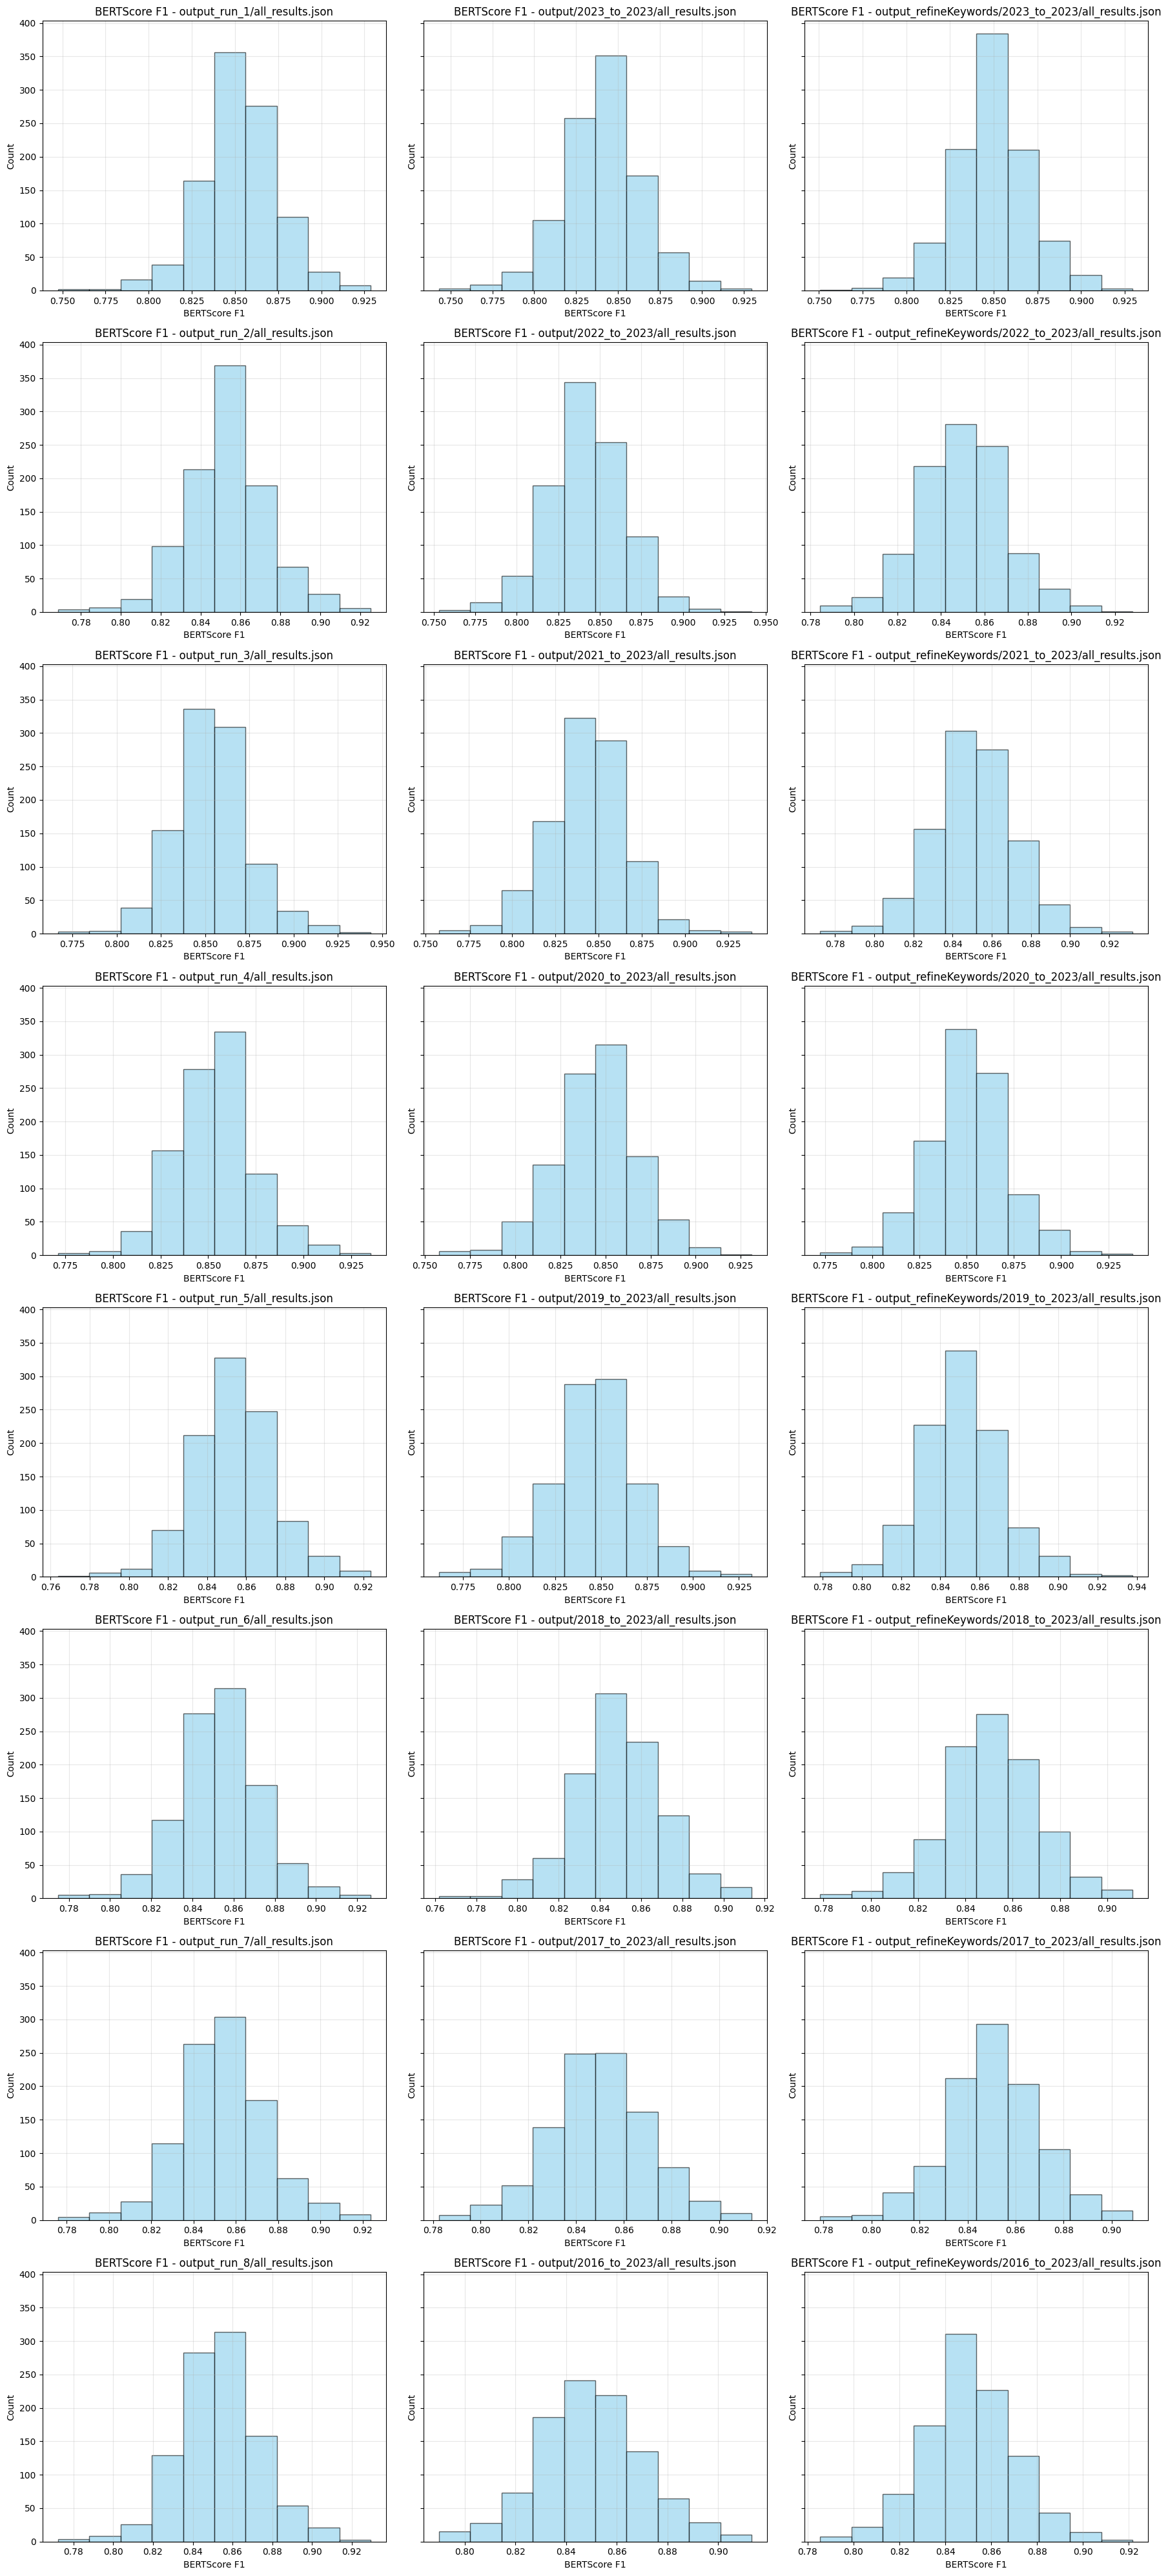

In [ ]:



# import matplotlib.pyplot as plt
# import numpy as np

# n_plots = len(data)
# cols = 3
# rows = n_plots // cols + int(n_plots % cols > 0)

# fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows), sharey=True)

# if isinstance(axes, np.ndarray):
#     axes = axes.flatten()
# else:
#     axes = [axes] 

# for ax, dataset in zip(axes, data):
#     raw_F1 = scores_all[dataset]["f1_score"]  # array-like of scores
#     ax.hist(raw_F1, bins=10, alpha=0.6, color='skyblue', edgecolor='black')
#     ax.set_title(f"BERTScore F1 - {dataset}")
#     ax.set_xlabel("BERTScore F1")
#     ax.set_ylabel("Count")
#     ax.grid(alpha=0.3)

# plt.tight_layout()
# plt.show()


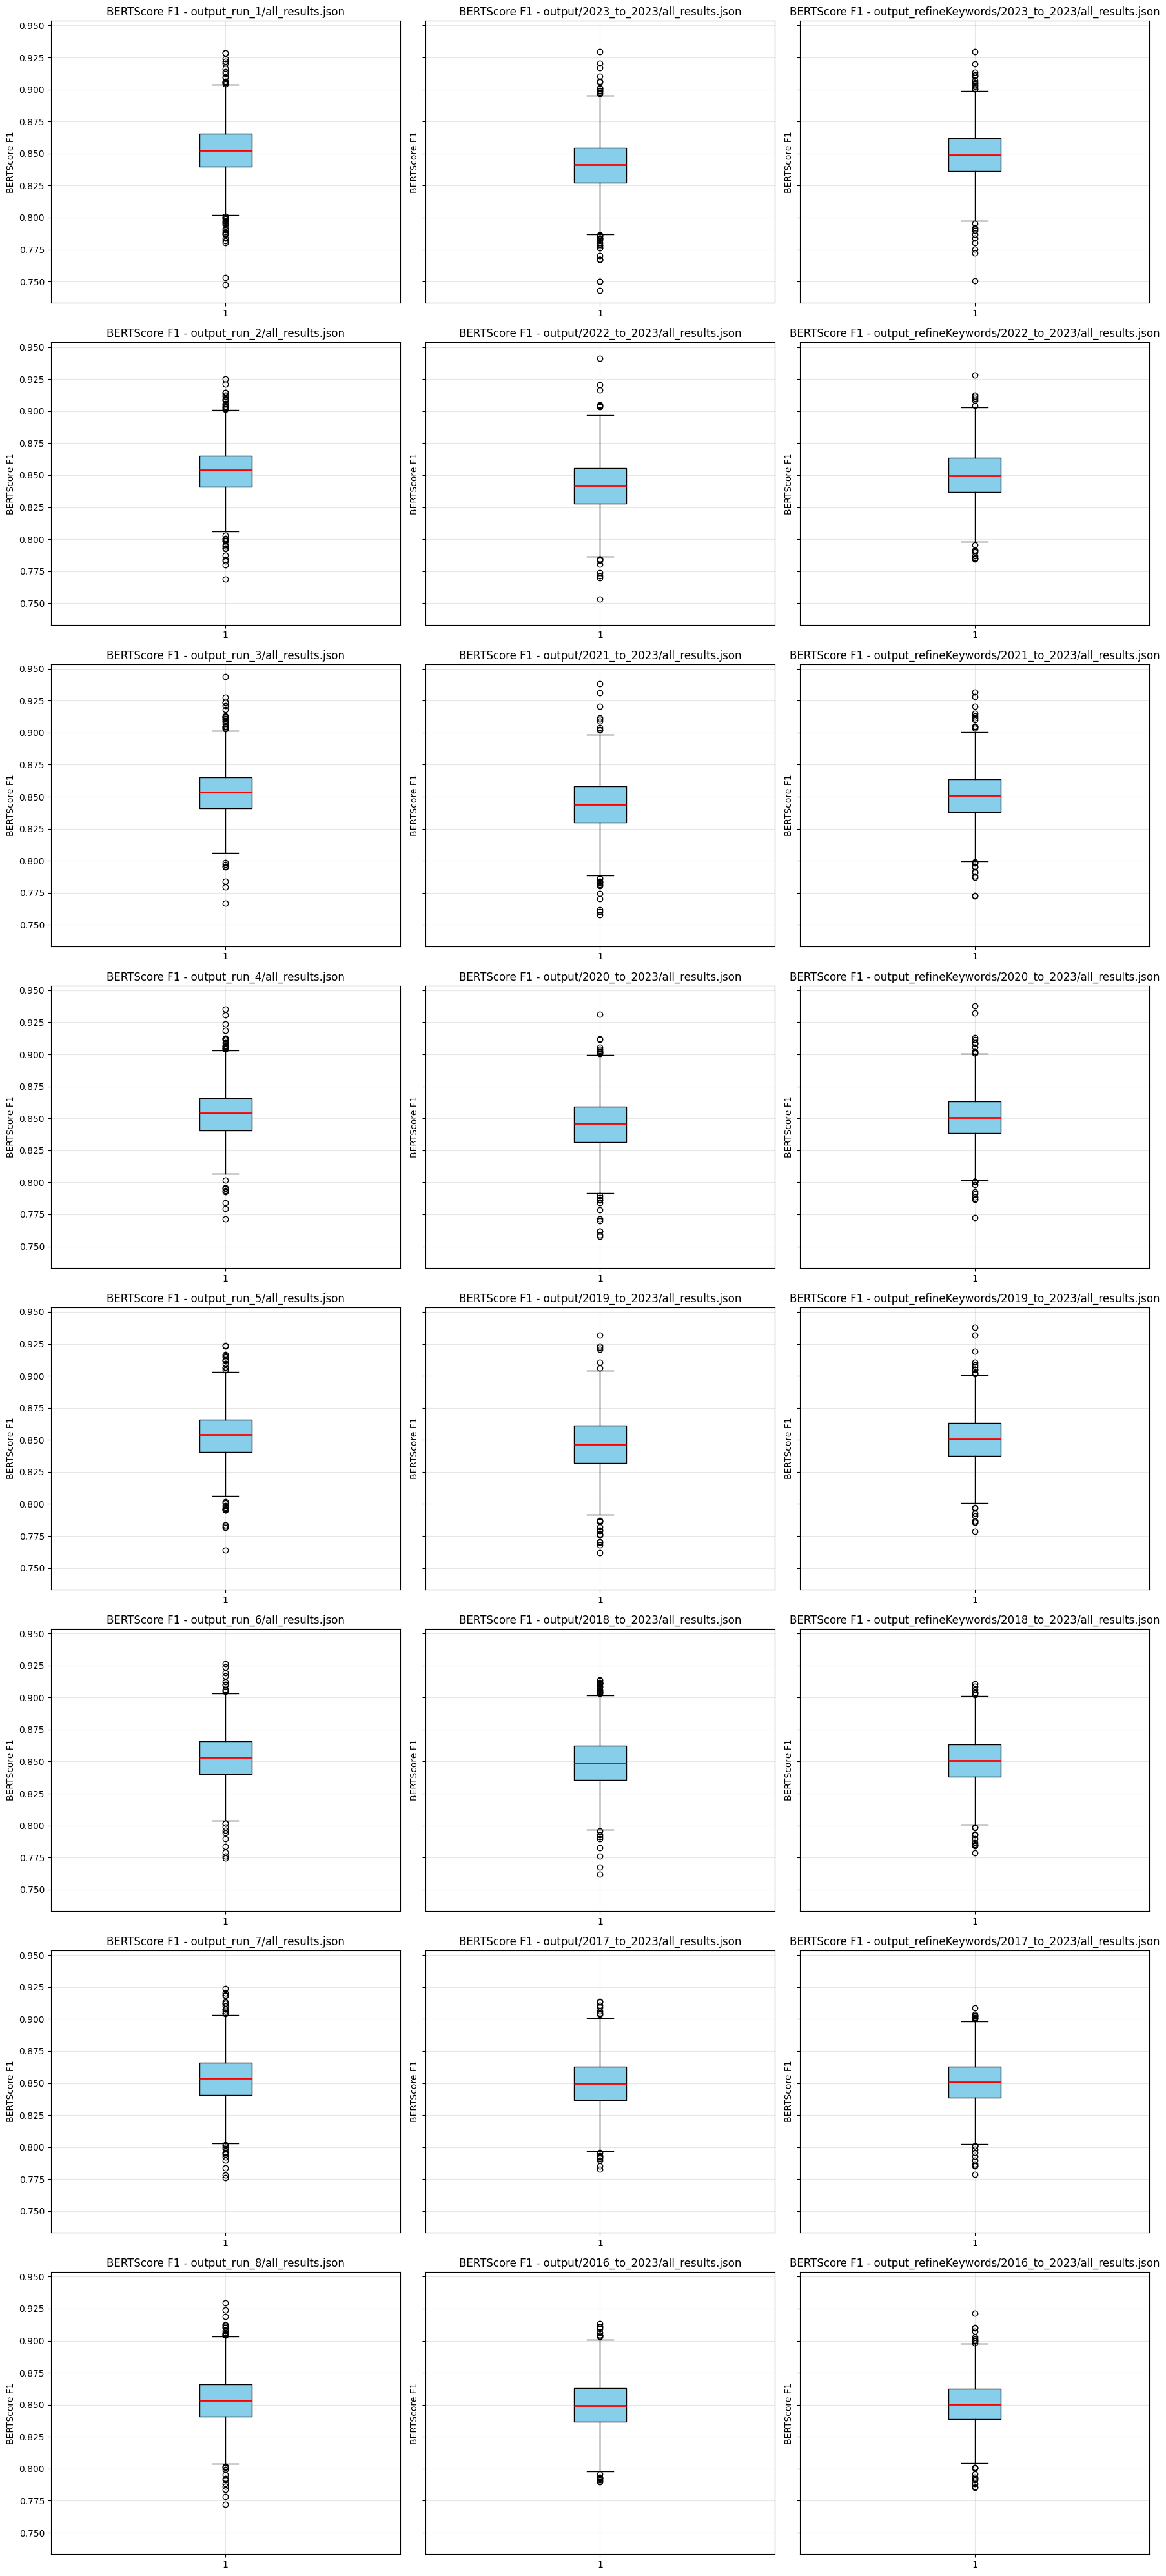

In [64]:
import matplotlib.pyplot as plt
import numpy as np

n_plots = len(data)
cols = 3
rows = n_plots // cols + int(n_plots % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows), sharey=True)

# Flatten axes for consistent iteration
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]

for ax, dataset in zip(axes, data):
    raw_F1 = scores_all[dataset]["f1_score"]  # array-like of scores
    
    # Box plot
    ax.boxplot(raw_F1, patch_artist=True,
               boxprops=dict(facecolor='skyblue', color='black'),
               medianprops=dict(color='red', linewidth=2),
               whiskerprops=dict(color='black'),
               capprops=dict(color='black'))
    
    ax.set_title(f"BERTScore F1 - {dataset}", fontsize=12)
    ax.set_ylabel("BERTScore F1", fontsize=10)
    ax.grid(alpha=0.3)

# Hide any unused subplots if n_plots < rows*cols
for ax in axes[len(data):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


In [65]:
for dataset in data:   
    mean_scores=scores_all[dataset]["mean_scores"]
    print(f"Dataset: {dataset} | Mean Precision: {mean_scores['precision']:.4f} | Mean Recall: {mean_scores['recall']:.4f} | Mean F1: {mean_scores['f1']:.4f}")

Dataset: output_run_1/all_results.json | Mean Precision: 0.8522 | Mean Recall: 0.8530 | Mean F1: 0.8525
Dataset: output/2023_to_2023/all_results.json | Mean Precision: 0.8471 | Mean Recall: 0.8352 | Mean F1: 0.8410
Dataset: output_refineKeywords/2023_to_2023/all_results.json | Mean Precision: 0.8529 | Mean Recall: 0.8459 | Mean F1: 0.8493
Dataset: output_run_2/all_results.json | Mean Precision: 0.8527 | Mean Recall: 0.8545 | Mean F1: 0.8535
Dataset: output/2022_to_2023/all_results.json | Mean Precision: 0.8478 | Mean Recall: 0.8367 | Mean F1: 0.8421
Dataset: output_refineKeywords/2022_to_2023/all_results.json | Mean Precision: 0.8529 | Mean Recall: 0.8476 | Mean F1: 0.8501
Dataset: output_run_3/all_results.json | Mean Precision: 0.8529 | Mean Recall: 0.8549 | Mean F1: 0.8538
Dataset: output/2021_to_2023/all_results.json | Mean Precision: 0.8488 | Mean Recall: 0.8383 | Mean F1: 0.8434
Dataset: output_refineKeywords/2021_to_2023/all_results.json | Mean Precision: 0.8536 | Mean Recall: 0.

In [66]:
import pandas as pd

# Prepare a list to store each row
table_rows = []

for dataset in data:
    mean_scores = scores_all[dataset]["mean_scores"]
    table_rows.append({
        "Dataset": dataset,
        # "Mean Precision": mean_scores['precision'],
        # "Mean Recall": mean_scores['recall'],
        "Mean F1": mean_scores['f1']
    })

# Create DataFrame
df_summary = pd.DataFrame(table_rows)

# Optional: format the floats for display
# df_summary["Mean Precision"] = df_summary["Mean Precision"].map("{:.4f}".format)
# df_summary["Mean Recall"] = df_summary["Mean Recall"].map("{:.4f}".format)
df_summary["Mean F1"] = df_summary["Mean F1"].map("{:.4f}".format)

# Display the table
print(df_summary)

# If you want, you can also save it to CSV
# df_summary.to_csv("mean_scores_summary.csv", index=False)


                                              Dataset Mean F1
0                       output_run_1/all_results.json  0.8525
1                output/2023_to_2023/all_results.json  0.8410
2   output_refineKeywords/2023_to_2023/all_results...  0.8493
3                       output_run_2/all_results.json  0.8535
4                output/2022_to_2023/all_results.json  0.8421
5   output_refineKeywords/2022_to_2023/all_results...  0.8501
6                       output_run_3/all_results.json  0.8538
7                output/2021_to_2023/all_results.json  0.8434
8   output_refineKeywords/2021_to_2023/all_results...  0.8510
9                       output_run_4/all_results.json  0.8540
10               output/2020_to_2023/all_results.json  0.8451
11  output_refineKeywords/2020_to_2023/all_results...  0.8511
12                      output_run_5/all_results.json  0.8536
13               output/2019_to_2023/all_results.json  0.8462
14  output_refineKeywords/2019_to_2023/all_results...  0.8508
15      

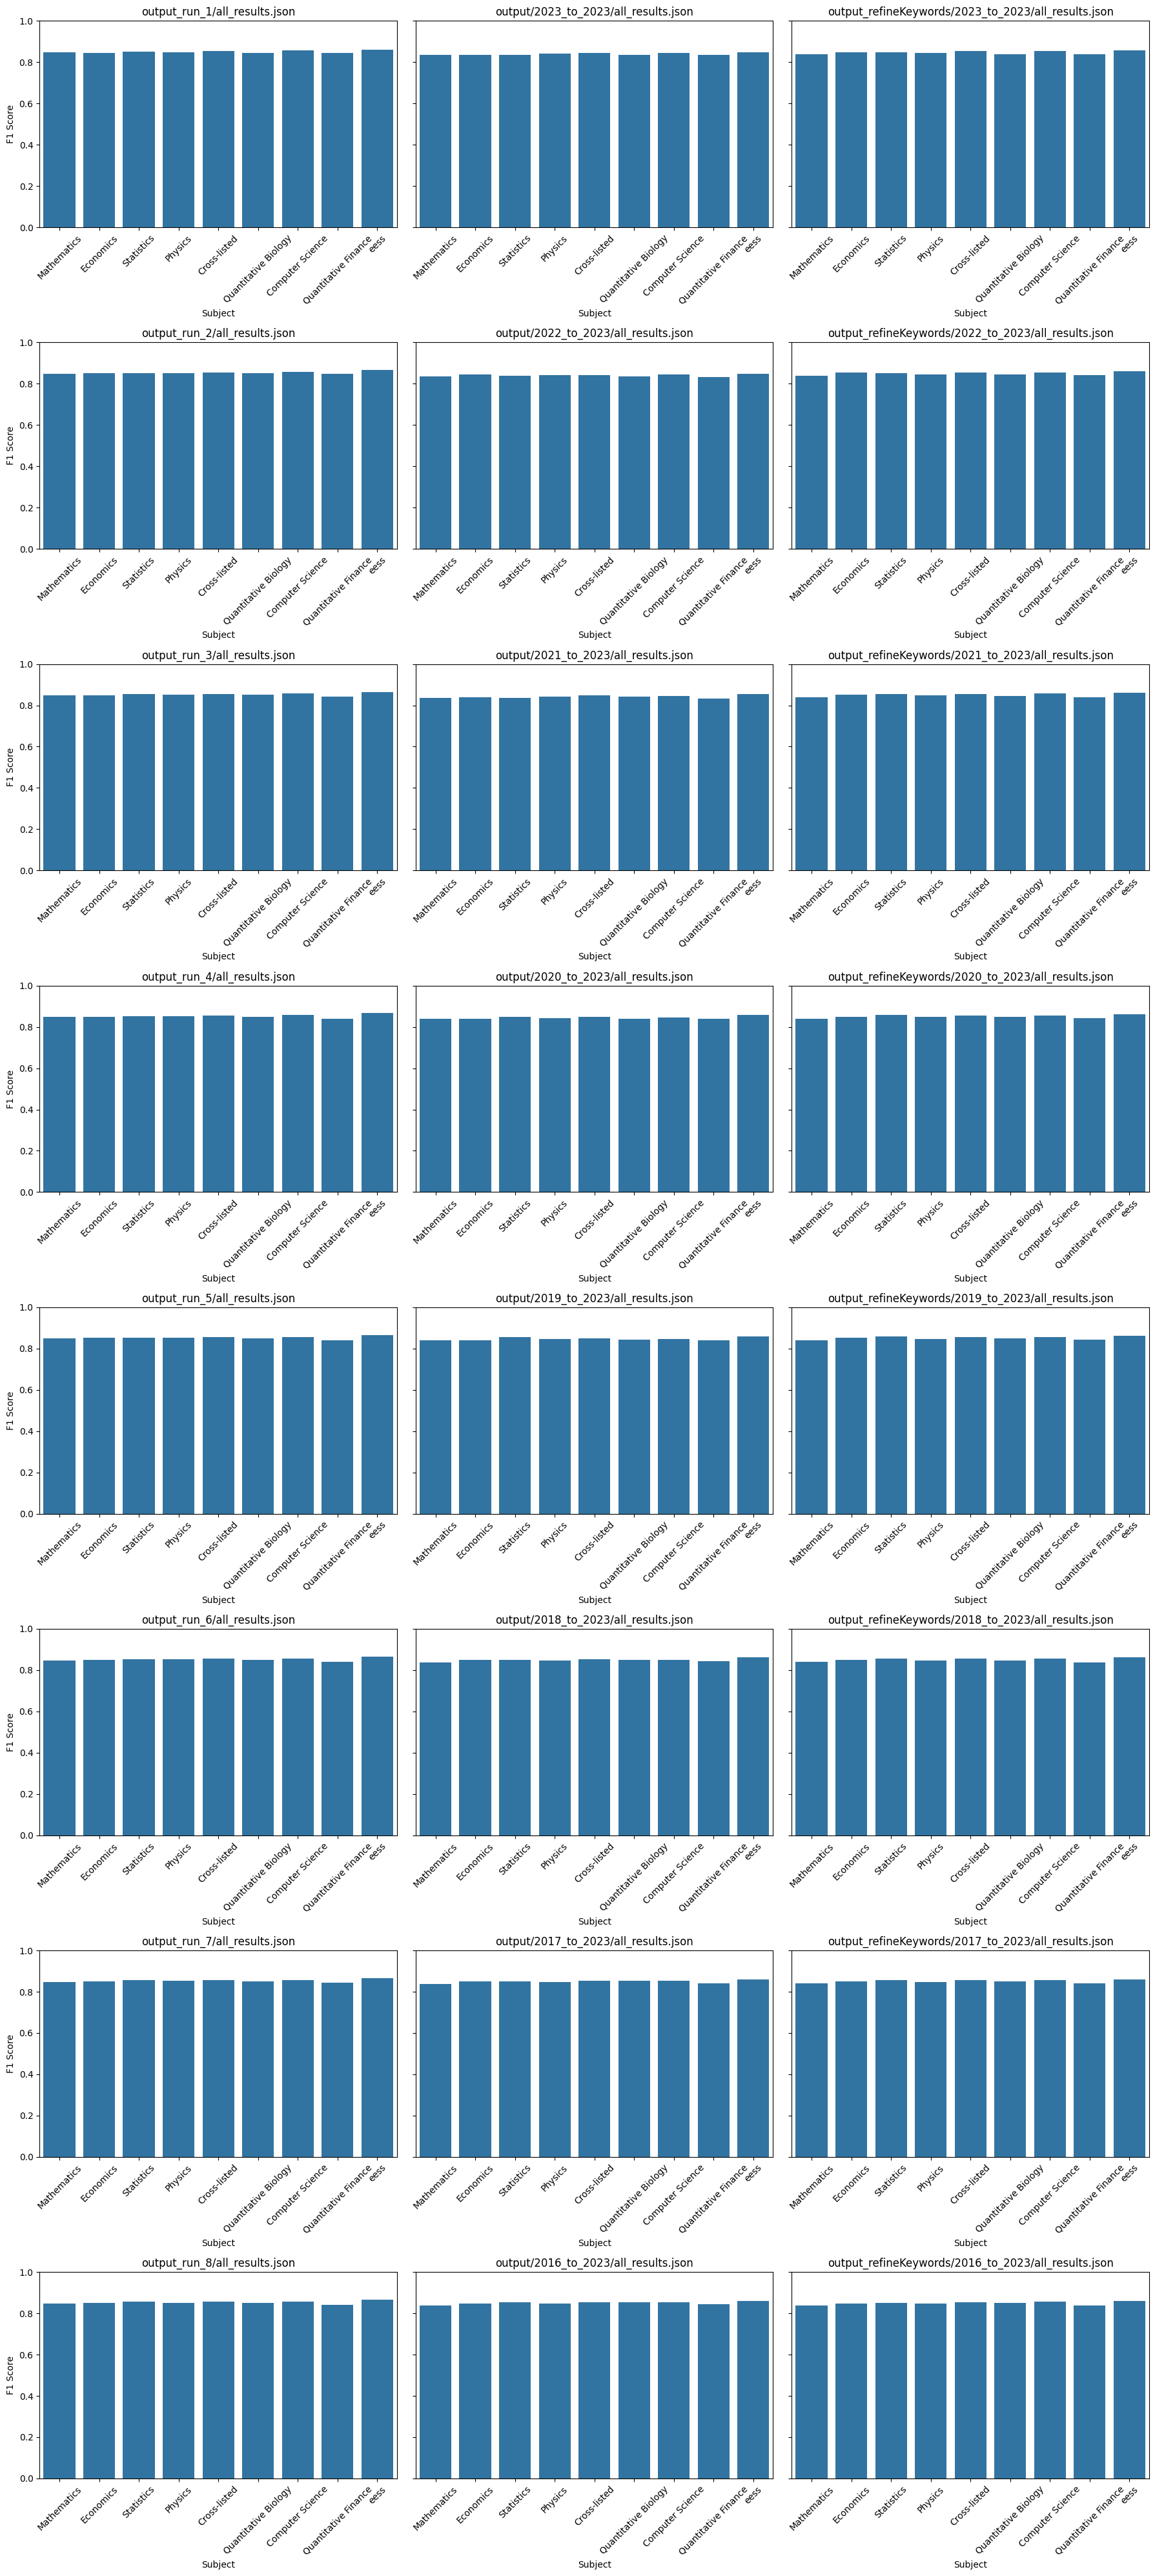

In [67]:
import matplotlib.pyplot as plt
import math
import seaborn as sns

num_datasets = len(data)
cols = 3
rows = math.ceil(num_datasets / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows), sharey=True)
axes = axes.flatten()

for i, dataset in enumerate(data):
    sbt = scores_all[dataset]["scores_by_topic"]  # could be {'Physics': {'precision':..., 'f1':...}, ...}
    
    # Make sure we take only F1 scores
    subjects = []
    f1_scores = []
    for subject, metrics in sbt.items():
        subjects.append(subject)
        f1_scores.append(metrics['f1'])  # take the F1 value

    sns.barplot(x=subjects, y=f1_scores, ax=axes[i])
    axes[i].set_title(dataset)
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel("F1 Score")
    axes[i].set_xlabel("Subject")
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


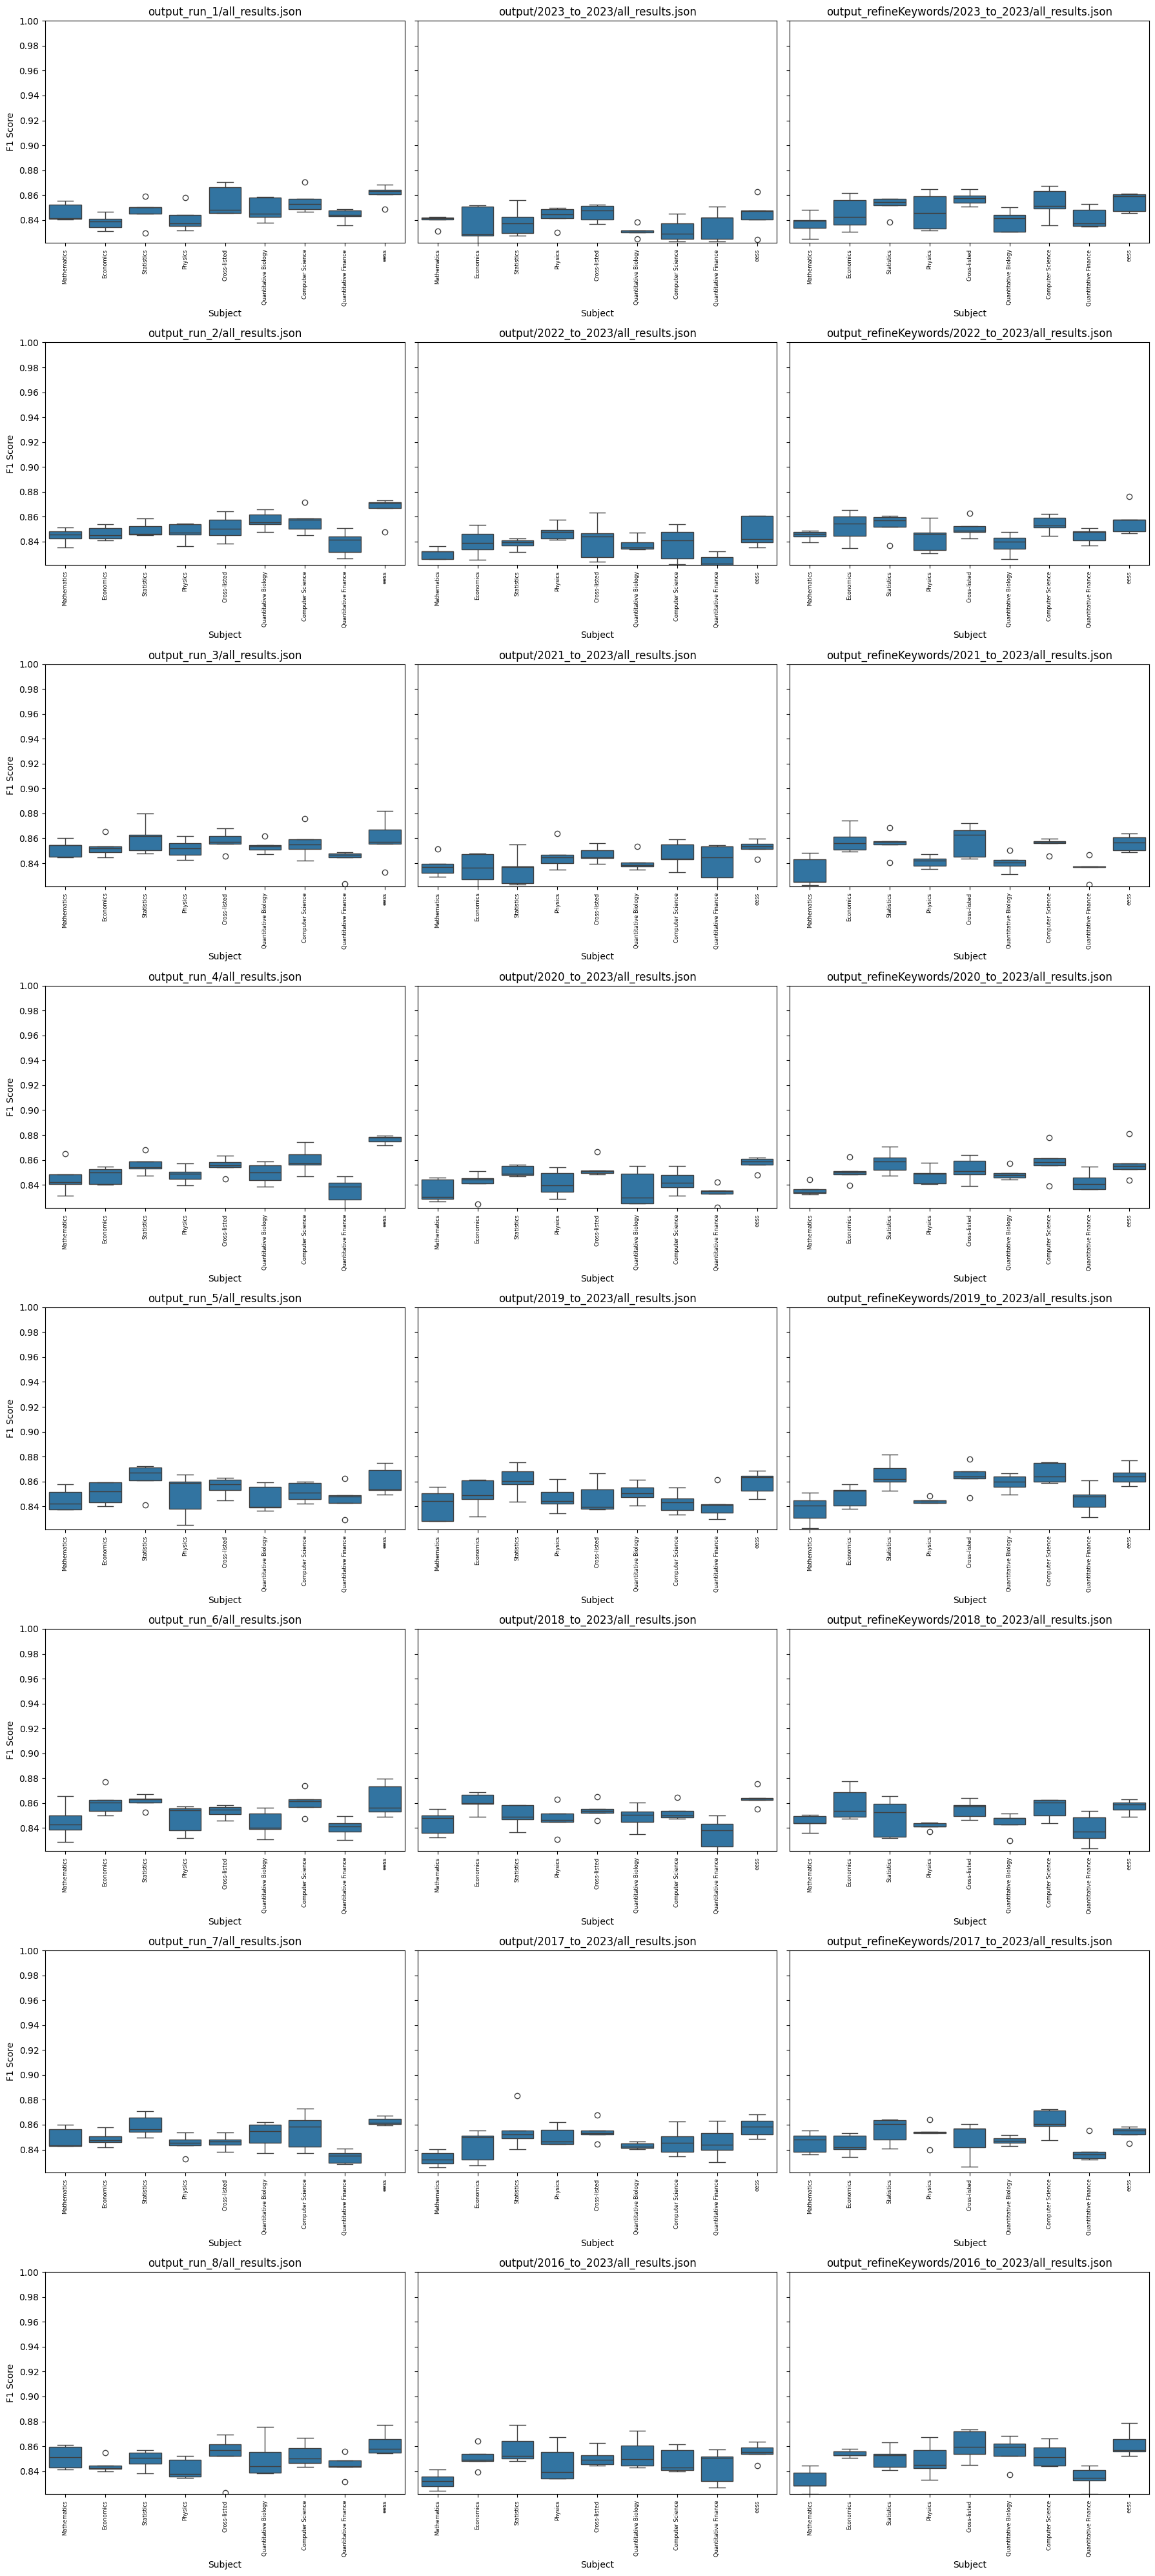

In [68]:
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd
import numpy as np

num_datasets = len(data)
cols = 3
rows = math.ceil(num_datasets / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows), sharey=True)
axes = axes.flatten()

for i, dataset in enumerate(data):
    sbt = scores_all[dataset]["scores_by_topic"]  # {'Physics': {'f1': 0.82, ...}, ...}
    
    df_list = []
    for subject, metrics in sbt.items():
        # simulate a small distribution around the F1 score for boxplot visualization
        f1_value = metrics['f1']
        f1_distribution = np.clip(np.random.normal(loc=f1_value, scale=0.01, size=5), 0, 1)
        for f1 in f1_distribution:
            df_list.append({'Subject': subject, 'F1': f1})
    
    df = pd.DataFrame(df_list)
    
    sns.boxplot(x='Subject', y='F1', data=df, ax=axes[i])
    axes[i].set_title(dataset)
    
    # y-scale from min F1 to 1
    min_f1 = df['F1'].min()
    axes[i].set_ylim(min_f1, 1)
    
    axes[i].set_ylabel("F1 Score")
    axes[i].set_xlabel("Subject")
    axes[i].tick_params(axis='x', rotation=90, labelsize=6)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


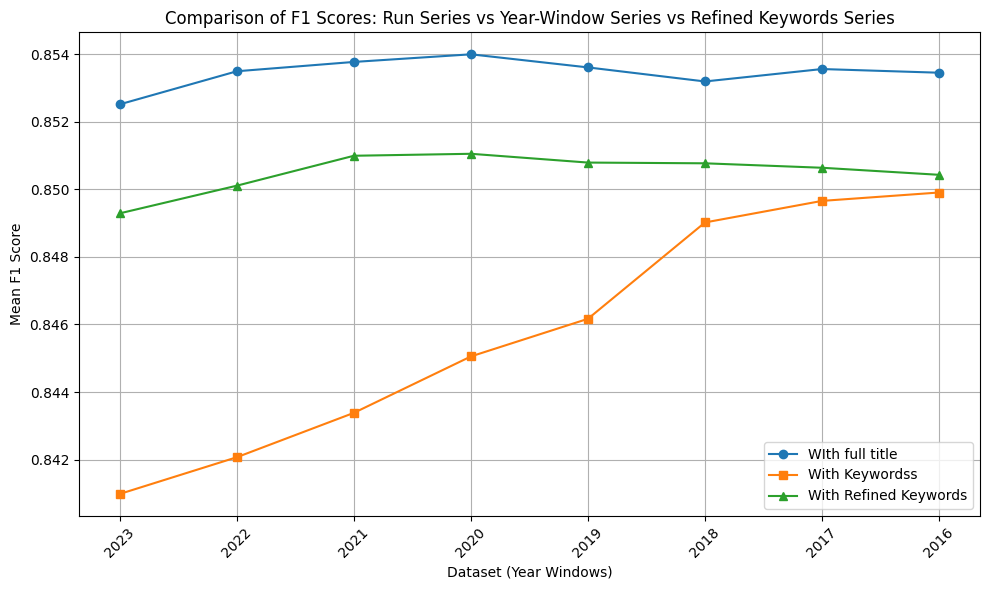

In [69]:
import matplotlib.pyplot as plt

# Original list
data = [
    "output_run_1/all_results.json",
    "output/2023_to_2023/all_results.json",
    "output_refineKeywords/2023_to_2023/all_results.json",
    "output_run_2/all_results.json",
    "output/2022_to_2023/all_results.json",
    "output_refineKeywords/2022_to_2023/all_results.json",
    "output_run_3/all_results.json",
    "output/2021_to_2023/all_results.json",
    "output_refineKeywords/2021_to_2023/all_results.json",
    "output_run_4/all_results.json",
    "output/2020_to_2023/all_results.json",
    "output_refineKeywords/2020_to_2023/all_results.json",
    "output_run_5/all_results.json",
    "output/2019_to_2023/all_results.json",
    "output_refineKeywords/2019_to_2023/all_results.json",
    "output_run_6/all_results.json",
    "output/2018_to_2023/all_results.json",
    "output_refineKeywords/2018_to_2023/all_results.json",
    "output_run_7/all_results.json",
    "output/2017_to_2023/all_results.json",
    "output_refineKeywords/2017_to_2023/all_results.json",
    "output_run_8/all_results.json",
    "output/2016_to_2023/all_results.json",
    "output_refineKeywords/2016_to_2023/all_results.json"
]

# Split series
run_series = [d for d in data if "output_run" in d]
year_series = [d for d in data if "output/" in d and "to_2023" in d and "output_refineKeywords" not in d] 
refine_series = [d for d in data if "output_refineKeywords" in d]

# Extract F1 scores
run_f1 = [scores_all[d]["mean_scores"]["f1"] for d in run_series]
year_f1 = [scores_all[d]["mean_scores"]["f1"] for d in year_series]
refine_f1 = [scores_all[d]["mean_scores"]["f1"] for d in refine_series]
# X-axis labels
x = list(range(1, len(run_f1) + 1))
run_labels = [f"run_{i}" for i in x]
year_labels = [d.split("/")[1].replace("_to_2023", "") for d in year_series]
refine_labels = [d.split("/")[1].replace("_to_2023", "") for d in refine_series]

# ---- combined line plot ----
plt.figure(figsize=(10, 6))

plt.plot(x, run_f1, marker='o', label="WIth full title")
plt.plot(x, year_f1, marker='s', label="With Keywordss")
plt.plot(x, refine_f1, marker='^', label="With Refined Keywords")

plt.xticks(x, year_labels, rotation=45)
plt.xlabel("Dataset (Year Windows)")
plt.ylabel("Mean F1 Score")
plt.title("Comparison of F1 Scores: Run Series vs Year-Window Series vs Refined Keywords Series")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Dataset: output_run_1/all_results.json | Mean  Precision: 0.8522 | Mean Recall: 0.8530 | Mean F1: 0.8525
Dataset: output/2023_to_2023/all_results.json | Mean  Precision: 0.8471 | Mean Recall: 0.8352 | Mean F1: 0.8410
Dataset: output_refineKeywords/2023_to_2023/all_results.json | Mean  Precision: 0.8529 | Mean Recall: 0.8459 | Mean F1: 0.8493
Dataset: output_run_2/all_results.json | Mean  Precision: 0.8527 | Mean Recall: 0.8545 | Mean F1: 0.8535
Dataset: output/2022_to_2023/all_results.json | Mean  Precision: 0.8478 | Mean Recall: 0.8367 | Mean F1: 0.8421
Dataset: output_refineKeywords/2022_to_2023/all_results.json | Mean  Precision: 0.8529 | Mean Recall: 0.8476 | Mean F1: 0.8501
Dataset: output_run_3/all_results.json | Mean  Precision: 0.8529 | Mean Recall: 0.8549 | Mean F1: 0.8538
Dataset: output/2021_to_2023/all_results.json | Mean  Precision: 0.8488 | Mean Recall: 0.8383 | Mean F1: 0.8434
Dataset: output_refineKeywords/2021_to_2023/all_results.json | Mean  Precision: 0.8536 | Mean R

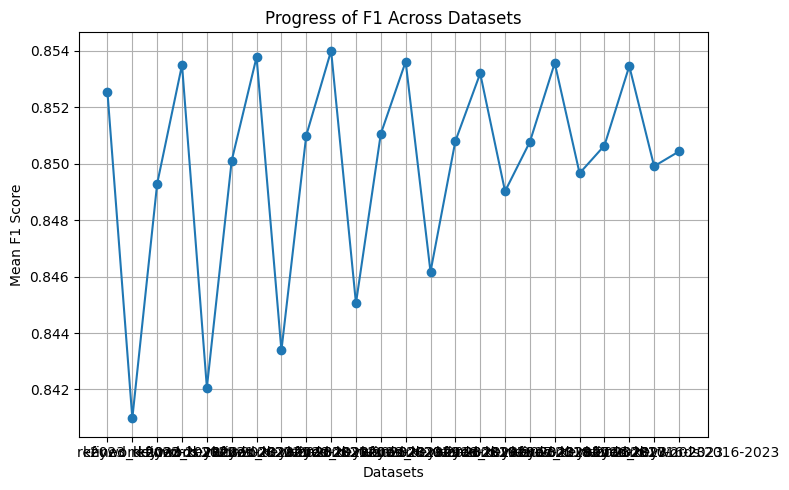

In [ ]:
data = [
    "output_run_1/all_results.json",
    "output/2023_to_2023/all_results.json",
    "output_refineKeywords/2023_to_2023/all_results.json",
    "output_run_2/all_results.json",
    "output/2022_to_2023/all_results.json",
    "output_refineKeywords/2022_to_2023/all_results.json",
    "output_run_3/all_results.json",
    "output/2021_to_2023/all_results.json",
    "output_refineKeywords/2021_to_2023/all_results.json",
    "output_run_4/all_results.json",
    "output/2020_to_2023/all_results.json",
    "output_refineKeywords/2020_to_2023/all_results.json",
    "output_run_5/all_results.json",
    "output/2019_to_2023/all_results.json",
    "output_refineKeywords/2019_to_2023/all_results.json",
    "output_run_6/all_results.json",
    "output/2018_to_2023/all_results.json",
    "output_refineKeywords/2018_to_2023/all_results.json",
    "output_run_7/all_results.json",
    "output/2017_to_2023/all_results.json",
    "output_refineKeywords/2017_to_2023/all_results.json",
    "output_run_8/all_results.json",
    "output/2016_to_2023/all_results.json",
    "output_refineKeywords/2016_to_2023/all_results.json"
]

for dataset in data:   
    mean_scores=scores_all[dataset]["mean_scores"]
    print(f"Dataset: {dataset} | Mean  Precision: {mean_scores['precision']:.4f} | Mean Recall: {mean_scores['recall']:.4f} | Mean F1: {mean_scores['f1']:.4f}")

v = ["2023", "keyword 2023","2022-2023","2021-2023", '2020-2023', '2019-2023', '2018-2023', '2017-2023', '2016-2023']  # or list(scores_all.keys())
datasets = list(data)
f1_scores = [scores_all[d]["mean_scores"]["f1"] for d in datasets]

plt.figure(figsize=(8, 5))
plt.plot(v, f1_scores, marker='o')
plt.xlabel("Datasets")
plt.ylabel("Mean F1 Score")
plt.title("Progress of F1 Across Datasets")
plt.grid(True)
plt.tight_layout()
plt.show()



In [73]:
def plot_similarity_histogram(pairwise_sims, avg_similarity, threshold, ax, title=None):
    """
    Plots a histogram of cosine similarity scores on the provided axis with mean and threshold lines.

    Args:
        pairwise_sims (torch.Tensor): Tensor of cosine similarity scores.
        avg_similarity (float): Average cosine similarity score.
        threshold (float): Threshold value to be marked on the histogram.
        ax (matplotlib.axes.Axes): Axis to plot on.
        title (str, optional): Title of the subplot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    similarity_scores = pairwise_sims.cpu().numpy()
    ax.hist(similarity_scores, bins=10, color='skyblue', edgecolor='black')

    ax.axvline(avg_similarity, color='red', linestyle='dashed', linewidth=1.5, label=f"Mean = {avg_similarity:.2f}")
    ax.axvline(threshold, color='orange', linestyle='dotted', linewidth=1.5, label=f"Threshold = {threshold}")

    ax.set_xlabel("Cosine Similarity", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    if title:
        ax.set_title(title, fontsize=14)
    ax.grid(alpha=0.3)
    ax.legend()

    # plt.tight_layout()
    # plt.show()

def plot_similarity_boxplot(pairwise_sims, avg_similarity, threshold, ax, title=None):
    """
    Plots a box plot of cosine similarity scores on the provided axis with mean and threshold lines.

    Args:
        pairwise_sims (torch.Tensor): Tensor of cosine similarity scores.
        avg_similarity (float): Average cosine similarity score.
        threshold (float): Threshold value to be marked on the plot.
        ax (matplotlib.axes.Axes): Axis to plot on.
        title (str, optional): Title of the subplot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    similarity_scores = pairwise_sims.cpu().numpy()

    # Box plot
    ax.boxplot(similarity_scores, patch_artist=True,
               boxprops=dict(facecolor='skyblue', color='black'),
               medianprops=dict(color='red', linewidth=2),
               whiskerprops=dict(color='black'),
               capprops=dict(color='black'))

    # Overlay mean and threshold lines
    ax.axhline(avg_similarity, color='green', linestyle='dashed', linewidth=1.5, label=f"Mean = {avg_similarity:.2f}")
    ax.axhline(threshold, color='orange', linestyle='dotted', linewidth=1.5, label=f"Threshold = {threshold}")

    ax.set_ylabel("Cosine Similarity", fontsize=12)
    if title:
        ax.set_title(title, fontsize=14)
    ax.grid(alpha=0.3)
    ax.legend()

def plot_similarity_boxplot_by_category(df, dataset_name, ax):
    categories = df['Category'].unique()   # <- Capital C
    data = [df[df['Category'] == c]['Cosine_Similarity'] for c in categories]

    ax.boxplot(data, labels=categories)
    ax.set_title(dataset_name)
    ax.set_ylabel("Cosine Similarity")
    ax.set_xticklabels(categories, rotation=45, ha='right')




   → Total pairs: 1000
   → Avg: 0.2548, Max: 0.8652, Min: -0.1351
   → Above threshold: 100 (10.00%)

   → Total pairs: 1000
   → Avg: 0.2390, Max: 0.8860, Min: -0.1719
   → Above threshold: 86 (8.60%)

   → Total pairs: 1000
   → Avg: 0.2469, Max: 0.8454, Min: -0.1322
   → Above threshold: 89 (8.90%)

   → Total pairs: 1000
   → Avg: 0.2658, Max: 0.8451, Min: -0.1079
   → Above threshold: 109 (10.90%)

   → Total pairs: 1000
   → Avg: 0.2505, Max: 0.8707, Min: -0.0997
   → Above threshold: 98 (9.80%)

   → Total pairs: 1000
   → Avg: 0.2622, Max: 0.8686, Min: -0.1603
   → Above threshold: 90 (9.00%)

   → Total pairs: 999
   → Avg: 0.2733, Max: 0.8482, Min: -0.1401
   → Above threshold: 111 (11.11%)

   → Total pairs: 1000
   → Avg: 0.2571, Max: 0.9002, Min: -0.0796
   → Above threshold: 93 (9.30%)

   → Total pairs: 1000
   → Avg: 0.2694, Max: 0.8686, Min: -0.1467
   → Above threshold: 102 (10.20%)

   → Total pairs: 1000
   → Avg: 0.2680, Max: 0.8558, Min: -0.1047
   → Above thresh

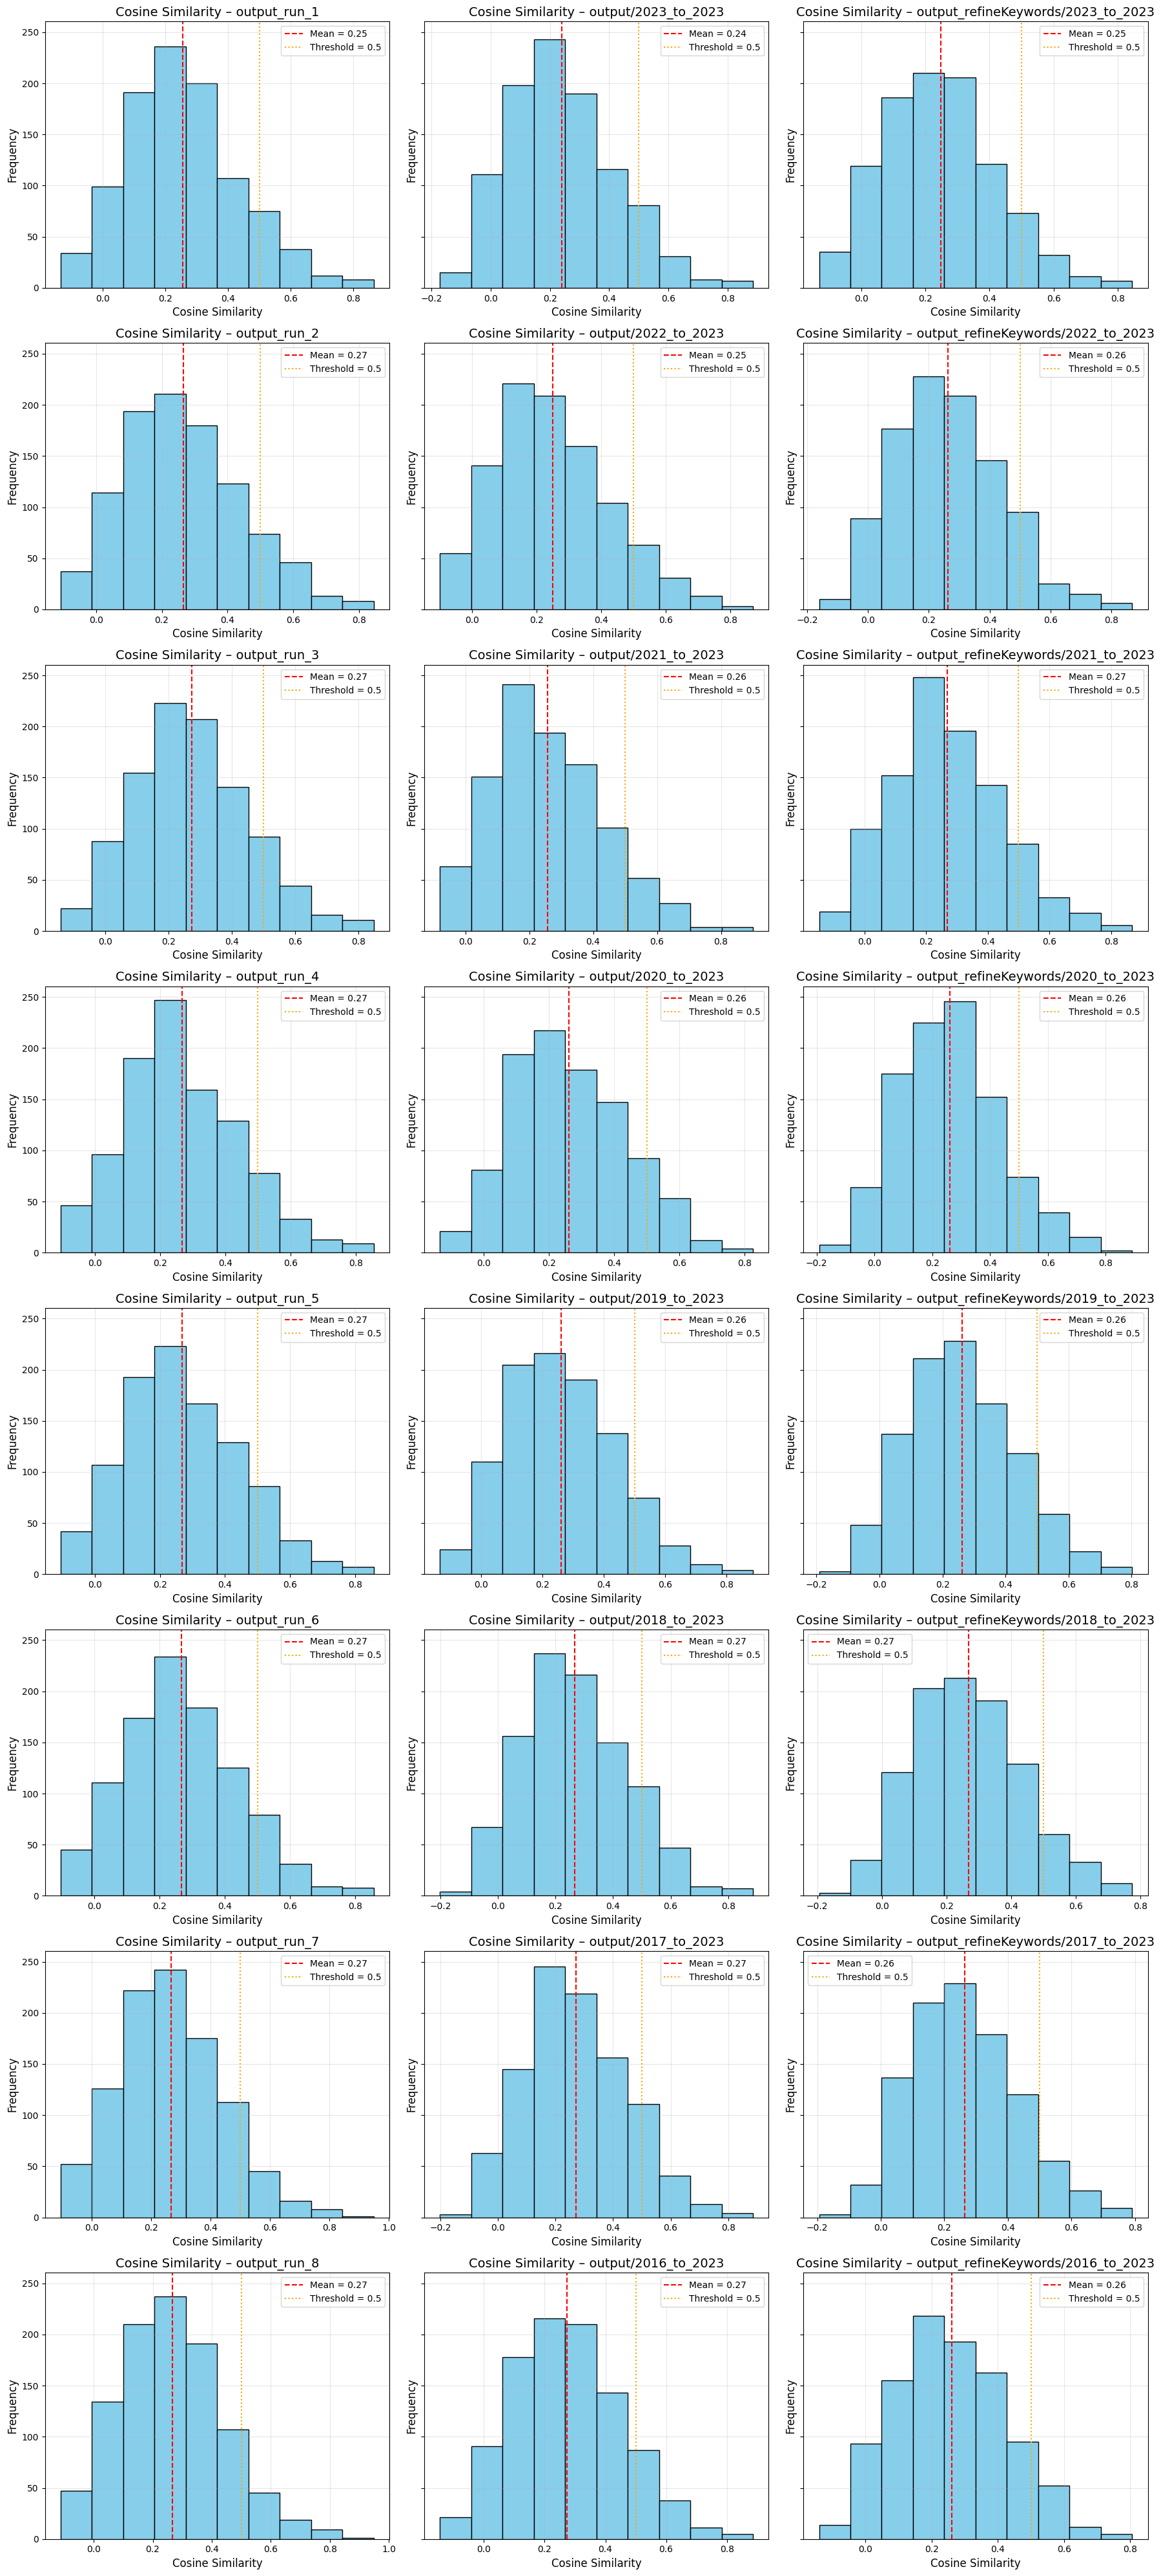

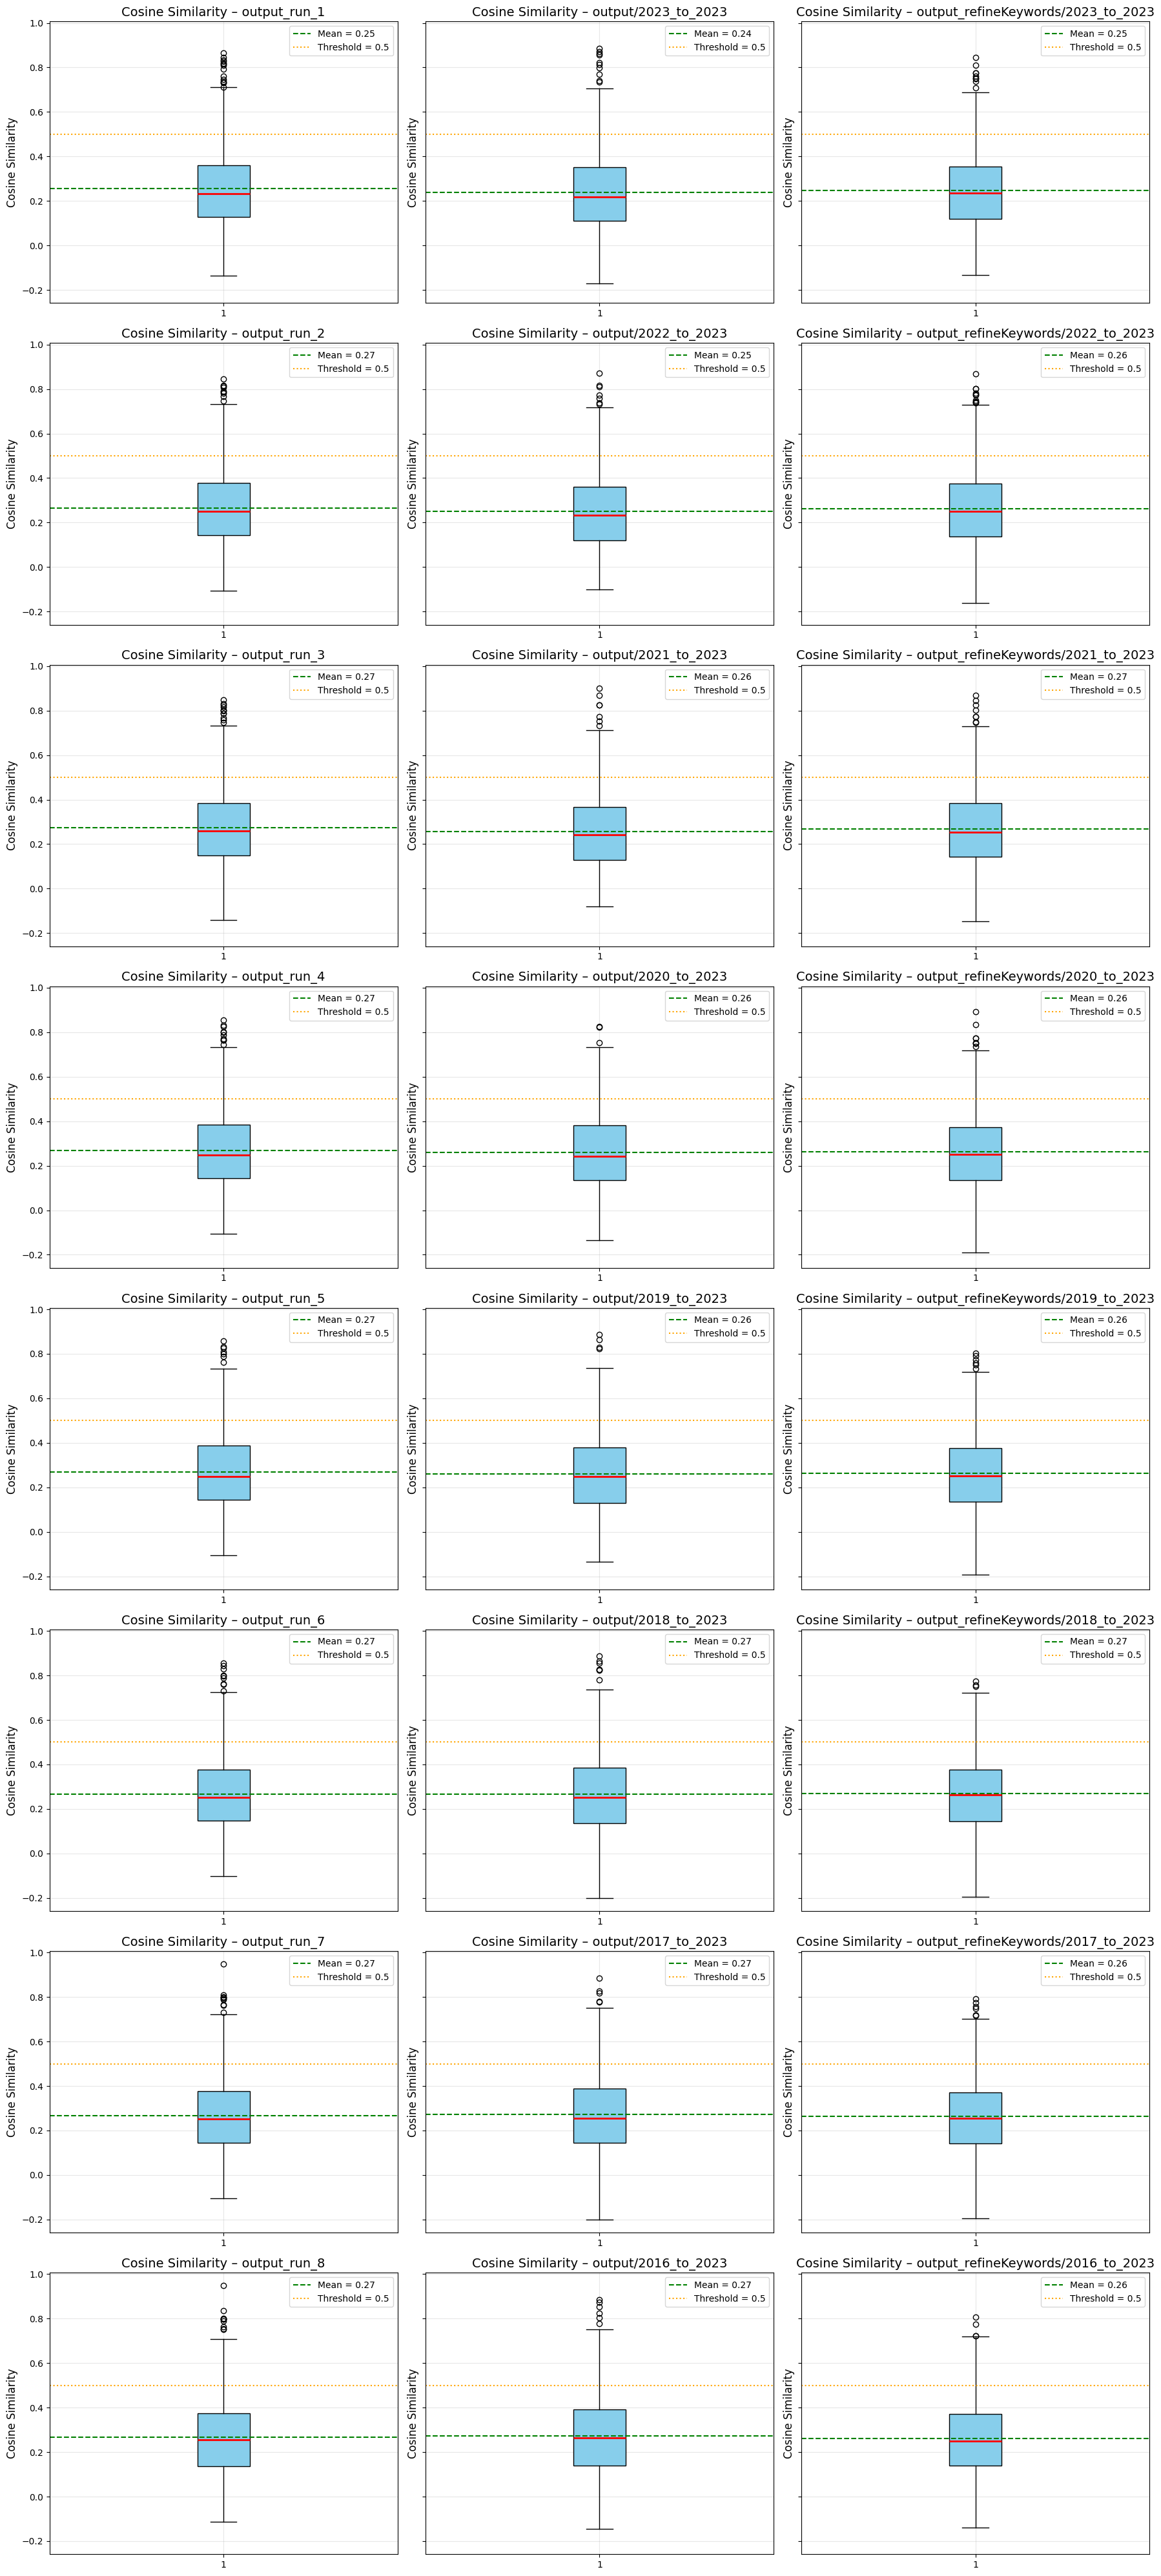

In [74]:
from sentence_transformers import SentenceTransformer, util
from sklearn import datasets
import torch
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


def calc_cosine_similarity(current_titles, results, past_titles, main_taxonomy):
    """
    Calculate cosine similarity between predicted and reference titles.
    Return DataFrame and summary statistics.
    """

    # Clean titles
    clean_ref, clean_output, clean_past_all, clean_category_all = clean_title_all(
        current_titles, results, past_titles, main_taxonomy
    )

    clean_ref = [x[0] if isinstance(x, (list, tuple)) else x for x in clean_ref]
    clean_output = [x[0] if isinstance(x, (list, tuple)) else x for x in clean_output]

    # Load embedder
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Encode
    emb_pred = model.encode(clean_output, convert_to_tensor=True)
    emb_ref = model.encode(clean_ref, convert_to_tensor=True)

    # Cosine similarity
    cos_sims = util.cos_sim(emb_pred, emb_ref)
    pairwise_sims = cos_sims.diag()

    # Stats
    avg_similarity = pairwise_sims.mean().item()
    max_similarity = pairwise_sims.max().item()
    min_similarity = pairwise_sims.min().item()

    threshold = 0.5
    above_threshold = (pairwise_sims > threshold).sum().item()
    total_pairs = len(pairwise_sims)
    percentage_above = (above_threshold / total_pairs) * 100

    # Build dataframe
    df = pd.DataFrame({
        "Pair_Index": list(range(1, total_pairs + 1)),
        "Predicted_Title": clean_output,
        "Reference_Title": clean_ref,
        "Category": clean_category_all,
        "Past": clean_past_all,
        "Cosine_Similarity": [sim.item() for sim in pairwise_sims]
    })

    return df, avg_similarity, max_similarity, min_similarity, above_threshold, total_pairs, percentage_above, threshold, pairwise_sims



# ----------------------------------------------------
# PROCESS EACH DATASET
# ----------------------------------------------------

datasets_dict = {}

data_files=[
    "output_run_1/all_results.json",
    "output/2023_to_2023/all_results.json",
    "output_refineKeywords/2023_to_2023/all_results.json",
    "output_run_2/all_results.json",
    "output/2022_to_2023/all_results.json",
    "output_refineKeywords/2022_to_2023/all_results.json",
    "output_run_3/all_results.json",
    "output/2021_to_2023/all_results.json",
    "output_refineKeywords/2021_to_2023/all_results.json",
    "output_run_4/all_results.json",
    "output/2020_to_2023/all_results.json",
    "output_refineKeywords/2020_to_2023/all_results.json",
    "output_run_5/all_results.json",
    "output/2019_to_2023/all_results.json",
    "output_refineKeywords/2019_to_2023/all_results.json",
    "output_run_6/all_results.json",
    "output/2018_to_2023/all_results.json",
    "output_refineKeywords/2018_to_2023/all_results.json",
    "output_run_7/all_results.json",
    "output/2017_to_2023/all_results.json",
    "output_refineKeywords/2017_to_2023/all_results.json",
    "output_run_8/all_results.json",
    "output/2016_to_2023/all_results.json",
    "output_refineKeywords/2016_to_2023/all_results.json"
]

all_dfs = {}
for dataset_path in data_files:

    run_name = os.path.dirname(dataset_path)   # e.g. "output_run_1"

    results = cleaned_data[dataset_path]["clean_output"]
    ref_titles = cleaned_data[dataset_path]["clean_ref"]
    past_titles = cleaned_data[dataset_path]["clean_past"]
    category = cleaned_data[dataset_path]["clean_category"]

    df, avg_similarity, max_similarity, min_similarity, above_threshold, total_pairs, pct_above, threshold, pairwise_sims = \
        calc_cosine_similarity(ref_titles, results, past_titles, category)

    # Summary row
    summary_row = pd.DataFrame({
        "Pair_Index": ["Summary"],
        "Predicted_Title": [""],
        "Reference_Title": [""],
        "Category": [""],
        "Past": [""],
        "Cosine_Similarity": [
            f"Avg={avg_similarity:.4f}, Max={max_similarity:.4f}, "
            f"Min={min_similarity:.4f}, >{threshold}={above_threshold} ({pct_above:.2f}%)"
        ]
    })

    df = pd.concat([df, summary_row], ignore_index=True)
    all_dfs[run_name] = df 

    # Save CSV
    # output_csv = f"cosine_similarity_{run_name}.csv"
    # df.to_csv(output_csv, index=False, encoding="utf-8-sig")

    # print(f"✅ Saved: {output_csv}")
    print(f"   → Total pairs: {total_pairs}")
    print(f"   → Avg: {avg_similarity:.4f}, Max: {max_similarity:.4f}, Min: {min_similarity:.4f}")
    print(f"   → Above threshold: {above_threshold} ({pct_above:.2f}%)\n")

    datasets_dict[run_name] = {
        "pairwise_sims": pairwise_sims,
        "avg_similarity": avg_similarity,
        "threshold": threshold,
    }


# ----------------------------------------------------
# HISTOGRAM PLOTS
# ----------------------------------------------------

n_plots = len(datasets_dict)
cols = 3
rows = (n_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows), sharey=True)
axes = axes.flatten()

for ax, (run_name, stats) in zip(axes, datasets_dict.items()):
    plot_similarity_histogram(
        pairwise_sims=stats["pairwise_sims"],
        avg_similarity=stats["avg_similarity"],
        threshold=stats["threshold"],
        ax=ax,
        title=f"Cosine Similarity – {run_name}",
    )

plt.tight_layout()
plt.show()


# ----------------------------------------------------
# BOXPLOTS
# ----------------------------------------------------

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows), sharey=True)
axes = axes.flatten()

for ax, (run_name, stats) in zip(axes, datasets_dict.items()):
    plot_similarity_boxplot(
        pairwise_sims=stats["pairwise_sims"],
        avg_similarity=stats["avg_similarity"],
        threshold=stats["threshold"],
        ax=ax,
        title=f"Cosine Similarity – {run_name}",
    )

plt.tight_layout()
plt.show()





In [52]:
len(all_dfs)

1

/tmp/ipykernel_3117687/2574000102.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=categories, patch_artist=True)
/tmp/ipykernel_3117687/2574000102.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=categories, patch_artist=True)
/tmp/ipykernel_3117687/2574000102.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=categories, patch_artist=True)
/tmp/ipykernel_3117687/2574000102.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in

/tmp/ipykernel_3117687/2574000102.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=categories, patch_artist=True)
/tmp/ipykernel_3117687/2574000102.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=categories, patch_artist=True)
/tmp/ipykernel_3117687/2574000102.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=categories, patch_artist=True)
/tmp/ipykernel_3117687/2574000102.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in

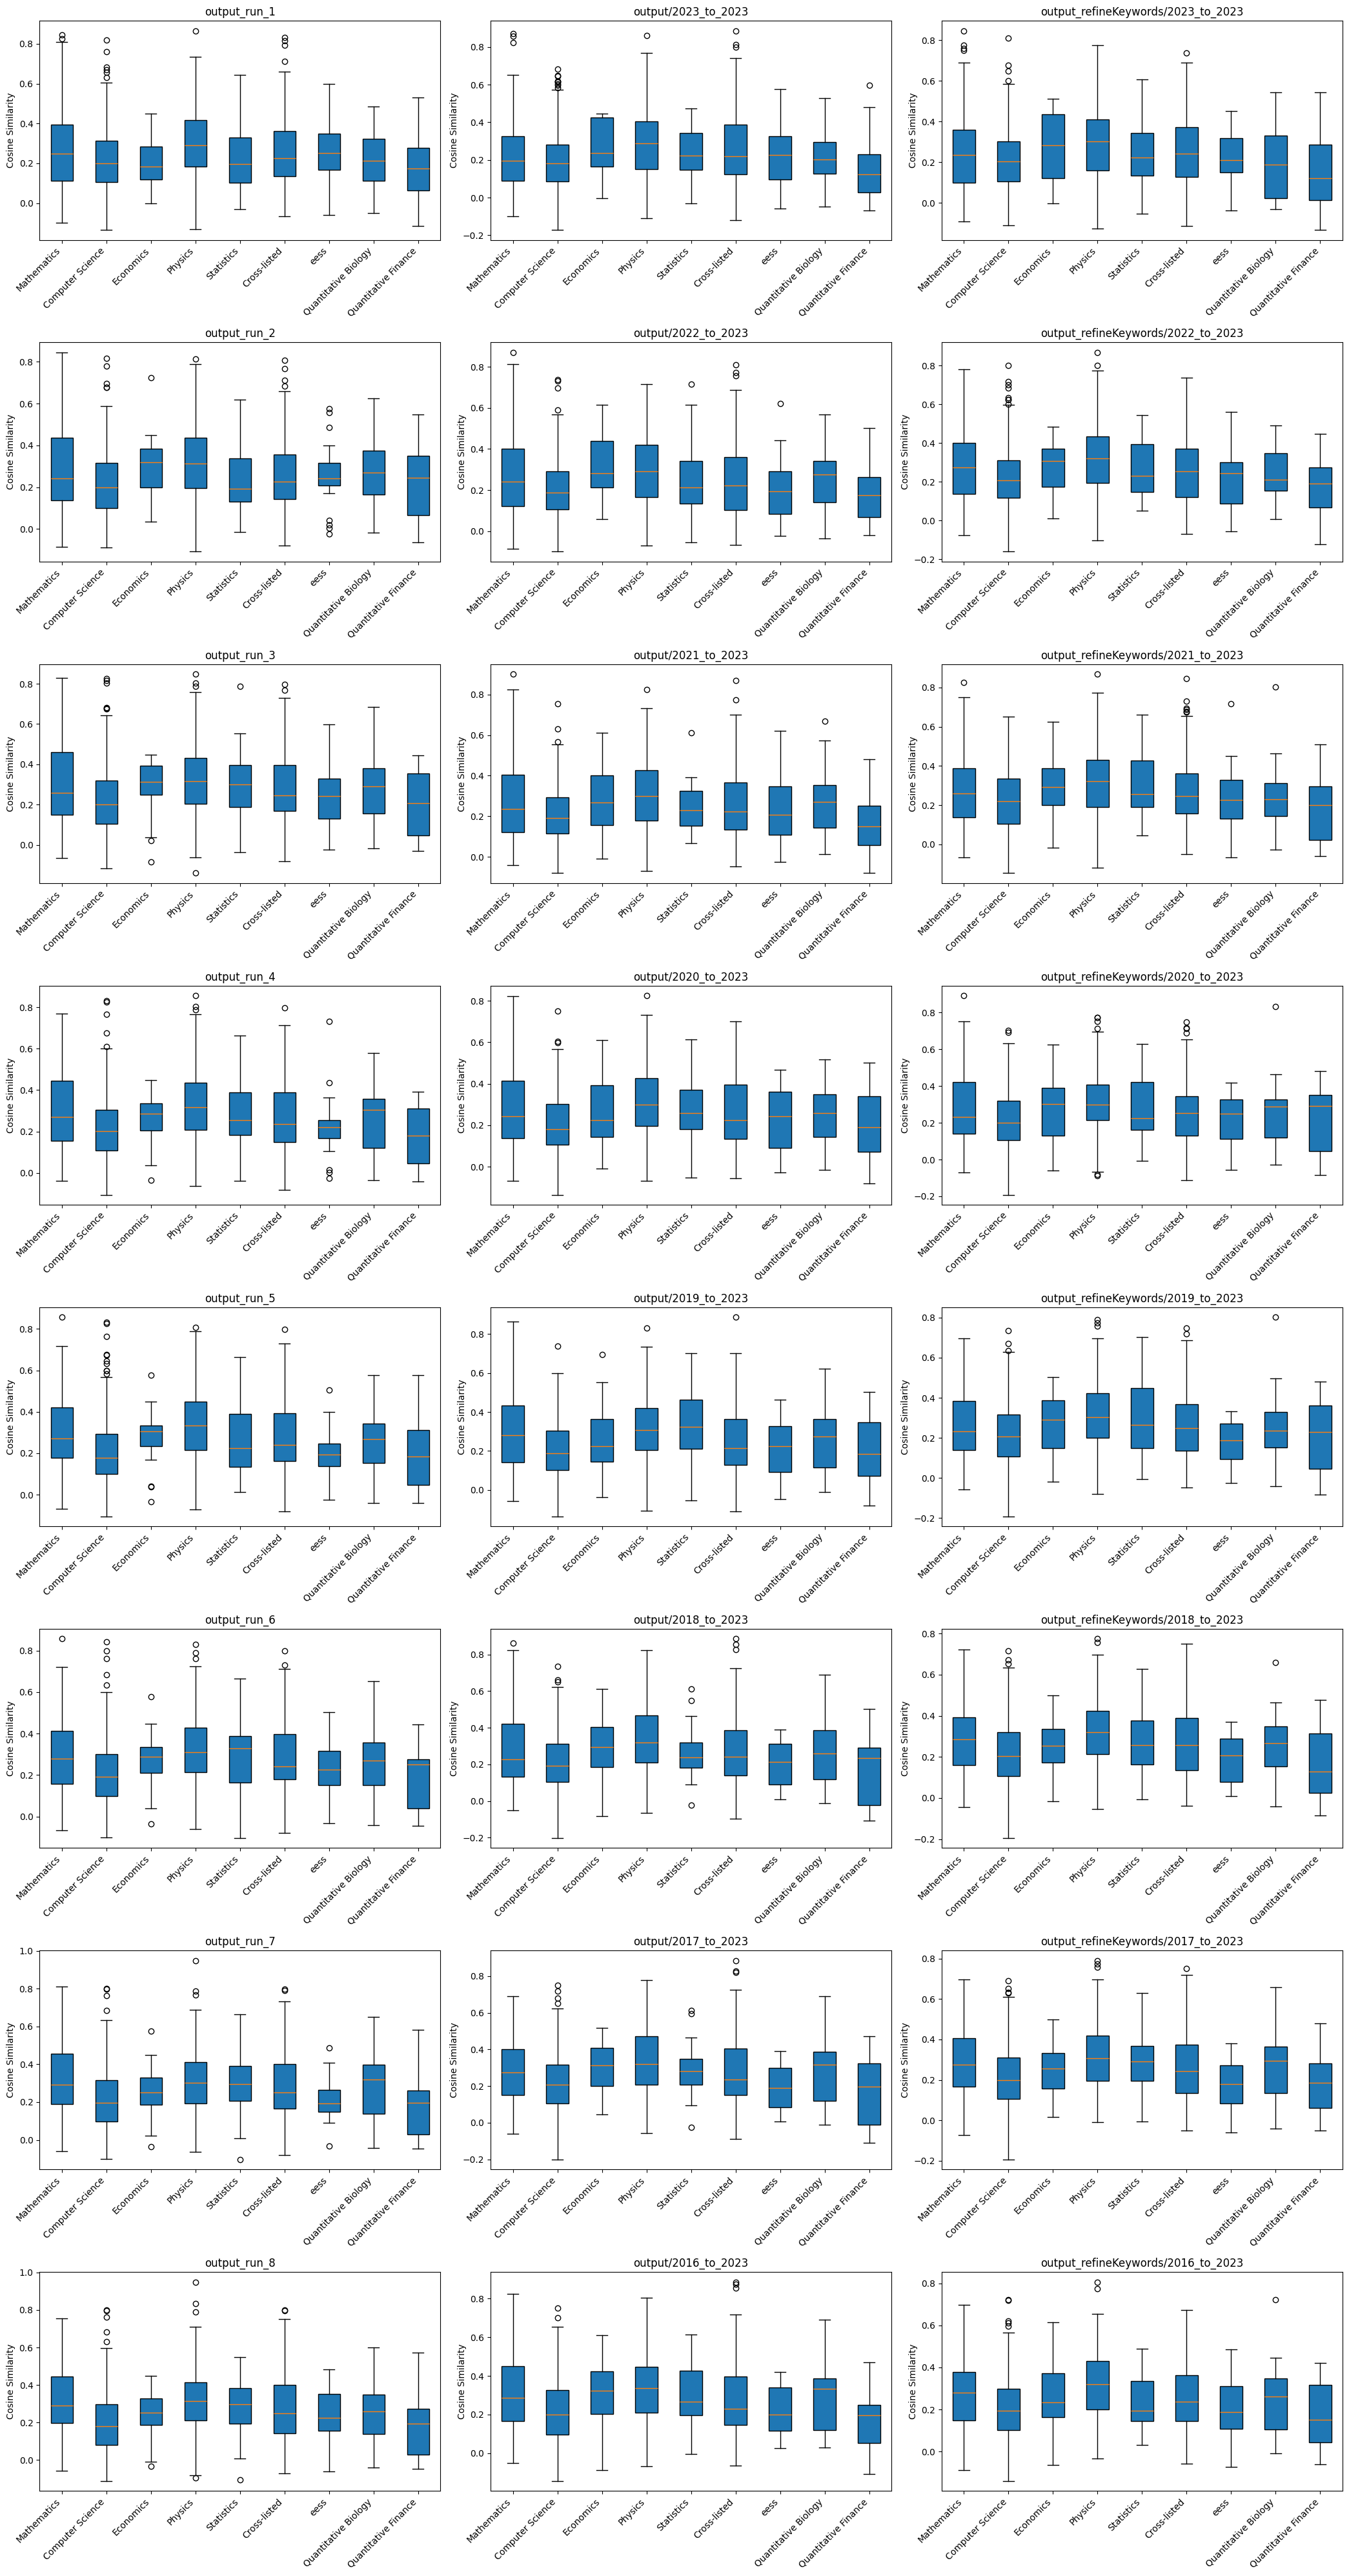

In [75]:


def plot_similarity_boxplot_by_category(df, dataset_name, ax):
    categories = df['Category'].unique()
    data = [df[df['Category'] == c]['Cosine_Similarity'] for c in categories]

    ax.boxplot(data, labels=categories, patch_artist=True)

    ax.set_title(dataset_name)
    ax.set_ylabel("Cosine Similarity")

    # Rotate x labels and reduce font size
    ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)



data_files = [
    "output_run_1/all_results.json",
    "output/2023_to_2023/all_results.json",
    "output_refineKeywords/2023_to_2023/all_results.json",
    "output_run_2/all_results.json",
    "output/2022_to_2023/all_results.json",
    "output_refineKeywords/2022_to_2023/all_results.json",
    "output_run_3/all_results.json",
    "output/2021_to_2023/all_results.json",
    "output_refineKeywords/2021_to_2023/all_results.json",
    "output_run_4/all_results.json",
    "output/2020_to_2023/all_results.json",
    "output_refineKeywords/2020_to_2023/all_results.json",
    "output_run_5/all_results.json",
    "output/2019_to_2023/all_results.json",
    "output_refineKeywords/2019_to_2023/all_results.json",
    "output_run_6/all_results.json",
    "output/2018_to_2023/all_results.json",
    "output_refineKeywords/2018_to_2023/all_results.json",
    "output_run_7/all_results.json",
    "output/2017_to_2023/all_results.json",
    "output_refineKeywords/2017_to_2023/all_results.json",
    "output_run_8/all_results.json",
    "output/2016_to_2023/all_results.json",
    "output_refineKeywords/2016_to_2023/all_results.json"
]

n_plots = len(data_files)
cols = 3
rows = (n_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows))
axes = axes.flatten()

for ax, dataset_path in zip(axes, data_files):
    run_name = os.path.dirname(dataset_path)
    df_run = all_dfs[run_name]

    df_plot = df_run[df_run["Pair_Index"] != "Summary"].copy()
    df_plot["Cosine_Similarity"] = pd.to_numeric(df_plot["Cosine_Similarity"], errors="coerce")

    plot_similarity_boxplot_by_category(
        df=df_plot,
        dataset_name=run_name,
        ax=ax                   # ← pass it here
    )

# Hide any unused axes
for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()





Dataset: output_run_1/all_results.json | Mean  Precision: 0.8522 | Mean Recall: 0.8530 | Mean F1: 0.8525
Dataset: output/2023_to_2023/all_results.json | Mean  Precision: 0.8471 | Mean Recall: 0.8352 | Mean F1: 0.8410
Dataset: output_refineKeywords/2023_to_2023/all_results.json | Mean  Precision: 0.8529 | Mean Recall: 0.8459 | Mean F1: 0.8493
Dataset: output_run_2/all_results.json | Mean  Precision: 0.8527 | Mean Recall: 0.8545 | Mean F1: 0.8535
Dataset: output/2022_to_2023/all_results.json | Mean  Precision: 0.8478 | Mean Recall: 0.8367 | Mean F1: 0.8421
Dataset: output_refineKeywords/2022_to_2023/all_results.json | Mean  Precision: 0.8529 | Mean Recall: 0.8476 | Mean F1: 0.8501
Dataset: output_run_3/all_results.json | Mean  Precision: 0.8529 | Mean Recall: 0.8549 | Mean F1: 0.8538
Dataset: output/2021_to_2023/all_results.json | Mean  Precision: 0.8488 | Mean Recall: 0.8383 | Mean F1: 0.8434
Dataset: output_refineKeywords/2021_to_2023/all_results.json | Mean  Precision: 0.8536 | Mean R

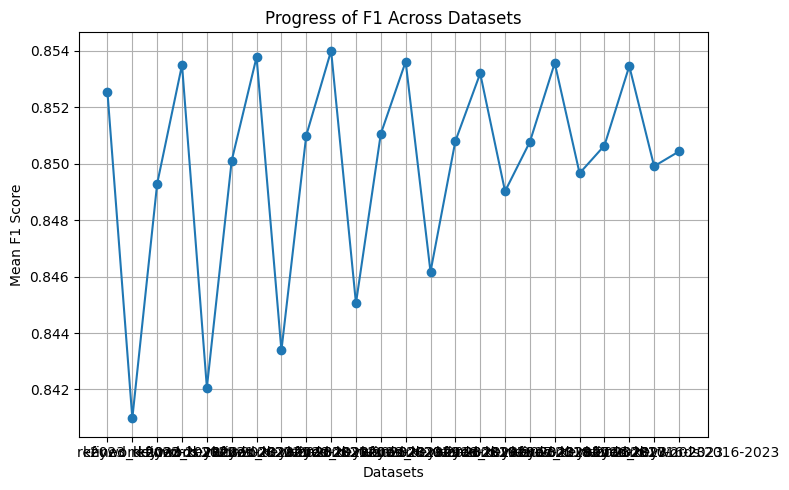

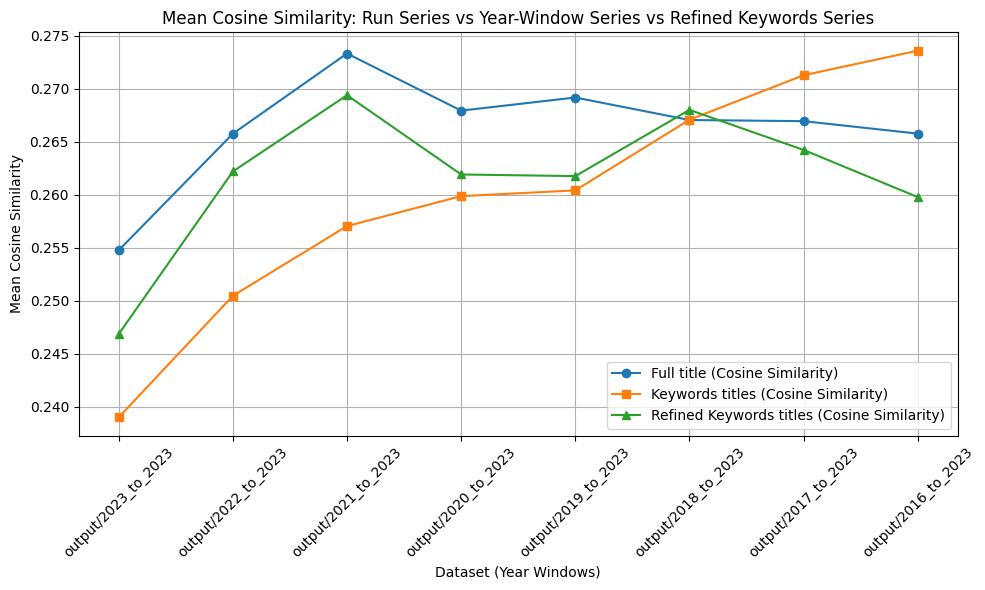

In [ ]:
# ----------------------------------------------------
# LINE PLOT – MEAN COSINE SIMILARITY (Two Series)
# ----------------------------------------------------

# Ordered file list (same order as input)
ordered_files = [
    "output_run_1/all_results.json",
    "output/2023_to_2023/all_results.json",
    "output_refineKeywords/2023_to_2023/all_results.json",
    "output_run_2/all_results.json",
    "output/2022_to_2023/all_results.json",
    "output_refineKeywords/2022_to_2023/all_results.json",
    "output_run_3/all_results.json",
    "output/2021_to_2023/all_results.json",
    "output_refineKeywords/2021_to_2023/all_results.json",
    "output_run_4/all_results.json",
    "output/2020_to_2023/all_results.json",
    "output_refineKeywords/2020_to_2023/all_results.json",
    "output_run_5/all_results.json",
    "output/2019_to_2023/all_results.json",
    "output_refineKeywords/2019_to_2023/all_results.json",
    "output_run_6/all_results.json",
    "output/2018_to_2023/all_results.json",
    "output_refineKeywords/2018_to_2023/all_results.json",
    "output_run_7/all_results.json",
    "output/2017_to_2023/all_results.json",
    "output_refineKeywords/2017_to_2023/all_results.json",
    "output_run_8/all_results.json",
    "output/2016_to_2023/all_results.json",
    "output_refineKeywords/2016_to_2023/all_results.json"
]

# for dataset in data:   
#     mean_scores=scores_all[dataset]["mean_scores"]
#     print(f"Dataset: {dataset} | Mean  Precision: {mean_scores['precision']:.4f} | Mean Recall: {mean_scores['recall']:.4f} | Mean F1: {mean_scores['f1']:.4f}")

# v = ["2023", "keyword 2023", "refined_keywords 2023","2022-2023", "keyword 2022-2023", "refined_keywords 2022-2023","2021-2023", "keyword 2021-2023", "refined_keywords 2021-2023", '2020-2023', 
#      "keyword 2020-2023", "refined_keywords 2020-2023", '2019-2023',  "keyword 2019-2023", "refined_keywords 2019-2023", '2018-2023', "keyword 2018-2023", "refined_keywords 2018-2023", '2017-2023', "keyword 2017-2023", "refined_keywords 2017-2023", '2016-2023', "keyword 2016-2023", "refined_keywords 2016-2023"]  # or list(scores_all.keys())
# datasets = list(data)
# f1_scores = [scores_all[d]["mean_scores"]["f1"] for d in datasets]

# plt.figure(figsize=(8, 5))
# plt.plot(v, f1_scores, marker='o')
# plt.xlabel("Datasets")
# plt.ylabel("Mean F1 Score")
# plt.title("Progress of F1 Across Datasets")
# plt.grid(True)
# plt.tight_layout()
# plt.show()




# Convert file paths → dict keys (folder names)
ordered = [os.path.dirname(f) for f in ordered_files]

# Split into 2 series
run_series = [x for x in ordered if x.startswith("output_run")]
year_series = [x for x in ordered if not x.startswith("output_run") and not x.startswith("output_refineKeywords")]
refine_series = [x for x in ordered if x.startswith("output_refineKeywords")]


# Extract mean cosine similarities
run_cos = [datasets_dict[s]["avg_similarity"] for s in run_series]
year_cos = [datasets_dict[s]["avg_similarity"] for s in year_series]
refine_cos = [datasets_dict[s]["avg_similarity"] for s in refine_series]

# X-axis
x = list(range(1, len(run_series) + 1))

# Labels for X-axis
x_labels = year_series  # e.g. 2023_to_2023 → 2016_to_2023

# -----------------------------
# Plot both lines on one figure
# -----------------------------
plt.figure(figsize=(10, 6))

plt.plot(x, run_cos, marker='o', label="Full title (Cosine Similarity)")
plt.plot(x, year_cos, marker='s', label="Keywords titles (Cosine Similarity)")
plt.plot(x, refine_cos, marker='^', label="Refined Keywords titles (Cosine Similarity)")

plt.xticks(x, x_labels, rotation=45)
plt.xlabel("Dataset (Year Windows)")
plt.ylabel("Mean Cosine Similarity")
plt.title("Mean Cosine Similarity: Run Series vs Year-Window Series vs Refined Keywords Series")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [46]:
datasets_dict

{'output_run_1': {'pairwise_sims': tensor([ 2.8098e-01,  5.9835e-01,  3.1230e-01,  2.7746e-01, -1.8841e-02,
           2.8198e-01,  2.1368e-01,  2.4996e-02, -8.2916e-02,  3.6161e-01,
           1.6398e-01,  5.5316e-01,  1.7313e-01,  6.4368e-01, -3.5328e-02,
           4.8701e-01,  1.2703e-01,  5.7132e-01,  7.5636e-02,  5.1483e-01,
           2.9448e-01,  5.8512e-01, -1.5407e-02,  4.3455e-01,  4.5170e-01,
          -1.5163e-02,  3.5112e-01, -4.5000e-02,  1.1867e-01, -1.0035e-01,
           2.6138e-01,  5.9494e-01, -7.5376e-02,  3.6192e-01,  3.7024e-01,
           6.1001e-01,  5.2814e-01,  3.6210e-01,  3.4853e-01,  1.8698e-01,
           5.4771e-02, -8.5758e-02, -3.3207e-02,  4.9399e-01,  1.3068e-01,
           3.6415e-01,  1.9034e-03,  2.1874e-02,  2.9896e-01,  7.1162e-01,
          -3.2342e-04,  4.6975e-01,  1.7224e-01,  1.7648e-01,  1.4195e-01,
           1.0033e-01,  8.2679e-01,  2.6871e-01,  9.2351e-02,  1.6076e-01,
           1.1091e-01,  2.8432e-01,  1.9938e-01,  4.2627e-02,  1.37

In [ ]:
import pandas as pd
ordered_files = [
    "output_run_1/all_results.json",
    "output/2023_to_2023/all_results.json",
    "output_refineKeywords/2023_to_2023/all_results.json",
    "output_run_2/all_results.json",
    "output/2022_to_2023/all_results.json",
    "output_refineKeywords/2022_to_2023/all_results.json",
    "output_run_3/all_results.json",
    "output/2021_to_2023/all_results.json",
    "output_refineKeywords/2021_to_2023/all_results.json",
    "output_run_4/all_results.json",
    "output/2020_to_2023/all_results.json",
    "output_refineKeywords/2020_to_2023/all_results.json",
    "output_run_5/all_results.json",
    "output/2019_to_2023/all_results.json",
    "output_refineKeywords/2019_to_2023/all_results.json",
    "output_run_6/all_results.json",
    "output/2018_to_2023/all_results.json",
    "output_refineKeywords/2018_to_2023/all_results.json",
    "output_run_7/all_results.json",
    "output/2017_to_2023/all_results.json",
    "output_refineKeywords/2017_to_2023/all_results.json",
    "output_run_8/all_results.json",
    "output/2016_to_2023/all_results.json",
    "output_refineKeywords/2016_to_2023/all_results.json"
]

# Convert file paths → dict keys (folder names)
ordered = [os.path.dirname(f) for f in ordered_files]
# print(ordered)
# Prepare a list for the table
table_rows = []

for s in ordered:
    avg_cos = datasets_dict[s]["avg_similarity"]
    table_rows.append({
        "Dataset": s,
        "Mean Cosine Similarity": avg_cos
    })

# Create DataFrame
df_cosine = pd.DataFrame(table_rows)

# Optional: format the similarity
df_cosine["Mean Cosine Similarity"] = df_cosine["Mean Cosine Similarity"].map("{:.4f}".format)

# Display the table
print(df_cosine)

# Optional: save to CSV
# df_cosine.to_csv("mean_cosine_similarity_table.csv", index=False)



                               Dataset Mean Cosine Similarity
0                         output_run_1                 0.2548
1                  output/2023_to_2023                 0.2390
2   output_refineKeywords/2023_to_2023                 0.2469
3                         output_run_2                 0.2658
4                  output/2022_to_2023                 0.2505
5   output_refineKeywords/2022_to_2023                 0.2622
6                         output_run_3                 0.2733
7                  output/2021_to_2023                 0.2571
8   output_refineKeywords/2021_to_2023                 0.2694
9                         output_run_4                 0.2680
10                 output/2020_to_2023                 0.2599
11  output_refineKeywords/2020_to_2023                 0.2619
12                        output_run_5                 0.2692
13                 output/2019_to_2023                 0.2604
14  output_refineKeywords/2019_to_2023                 0.2618
15      

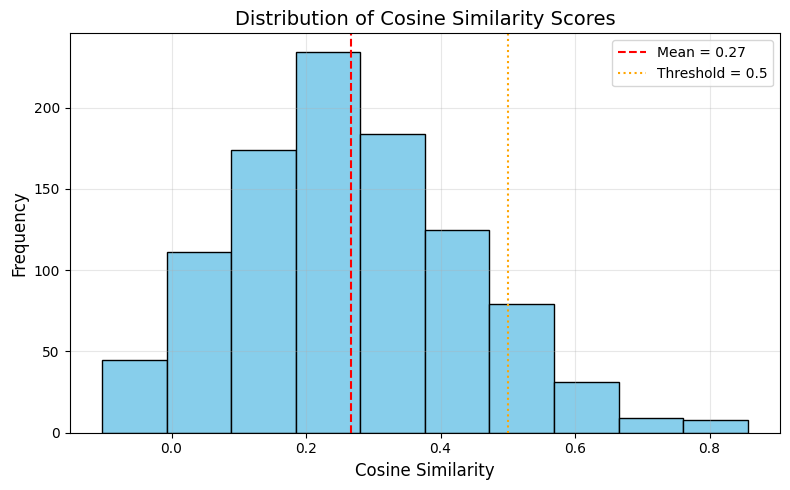

In [46]:
import matplotlib.pyplot as plt

# Convert tensor to numpy for plotting
similarity_scores = pairwise_sims.cpu().numpy()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(similarity_scores, bins=10, color='skyblue', edgecolor='black')

# Add mean line
plt.axvline(avg_similarity, color='red', linestyle='dashed', linewidth=1.5, label=f"Mean = {avg_similarity:.2f}")
plt.axvline(threshold, color='orange', linestyle='dotted', linewidth=1.5, label=f"Threshold = {threshold}")

# Add labels and title
plt.title("Distribution of Cosine Similarity Scores", fontsize=14)
plt.xlabel("Cosine Similarity", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
n_plots = len(datasets_dict)
cols = 3
rows = (n_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows), sharey=True)
axes = axes.flatten()

for ax, (run_name, stats) in zip(axes, datasets_dict.items()):
    plot_similarity_histogram(
        pairwise_sims=stats["pairwise_sims"],
        avg_similarity=stats["avg_similarity"],
        threshold=stats["threshold"],
        ax=ax,
        title=f"Cosine Similarity – {run_name}",
    )

plt.tight_layout()
plt.show()

In [146]:
deepseek2={'Mathematics': {'precision': 0.840532124042511,
  'recall': 0.8383917212486267,
  'f1': 0.8392839431762695},
 'Computer Science': {'precision': 0.8474664688110352,
  'recall': 0.8399720191955566,
  'f1': 0.8435860872268677},
 'Economics': {'precision': 0.842680811882019,
  'recall': 0.8409053683280945,
  'f1': 0.8416788578033447},
 'Physics': {'precision': 0.8418506383895874,
  'recall': 0.836925745010376,
  'f1': 0.8392073512077332},
 'Quantitative Finance': {'precision': 0.8328903913497925,
  'recall': 0.8397383093833923,
  'f1': 0.8361369967460632},
 'Quantitative Biology': {'precision': 0.8433038592338562,
  'recall': 0.836542010307312,
  'f1': 0.8397709727287292},
 'eess': {'precision': 0.8512998819351196,
  'recall': 0.8428025841712952,
  'f1': 0.8469115495681763},
 'Statistics': {'precision': 0.8452257513999939,
  'recall': 0.8407485485076904,
  'f1': 0.8428470492362976}}

In [ ]:
llama2={'Mathematics': {'precision': 0.8370917439460754,
  'recall': 0.8387895822525024,
  'f1': 0.8377348780632019},
 'Computer Science': {'precision': 0.8403977751731873,
  'recall': 0.8392849564552307,
  'f1': 0.8397050499916077},
 'Economics': {'precision': 0.8389202952384949,
  'recall': 0.8355952501296997,
  'f1': 0.8371490836143494},
 'Physics': {'precision': 0.8371689319610596,
  'recall': 0.8371060490608215,
  'f1': 0.8369199633598328},
 'Quantitative Finance': {'precision': 0.8331791758537292,
  'recall': 0.8377033472061157,
  'f1': 0.8352668285369873},
 'Quantitative Biology': {'precision': 0.8375545144081116,
  'recall': 0.8376448154449463,
  'f1': 0.8374302983283997},
 'eess': {'precision': 0.8451259136199951,
  'recall': 0.8414486050605774,
  'f1': 0.8431450128555298},
 'Statistics': {'precision': 0.8406499624252319,
  'recall': 0.8394355177879333,
  'f1': 0.8398875594139099}}

{'Mathematics': {'precision': 0.8399988412857056,
  'recall': 0.8199405670166016,
  'f1': 0.8296914100646973},
 'Computer Science': {'precision': 0.8492172956466675,
  'recall': 0.8352080583572388,
  'f1': 0.8420159816741943},
 'Economics': {'precision': 0.8403371572494507,
  'recall': 0.8334037661552429,
  'f1': 0.8366832137107849},
 'Physics': {'precision': 0.8412030339241028,
  'recall': 0.8218425512313843,
  'f1': 0.8312655091285706},
 'Quantitative Finance': {'precision': 0.8482365012168884,
  'recall': 0.8367239832878113,
  'f1': 0.8423416018486023},
 'Quantitative Biology': {'precision': 0.8411706686019897,
  'recall': 0.8319160342216492,
  'f1': 0.8364019393920898},
 'eess': {'precision': 0.8513780236244202,
  'recall': 0.8347882032394409,
  'f1': 0.8428746461868286},
 'Statistics': {'precision': 0.8464691042900085,
  'recall': 0.829296886920929,
  'f1': 0.8376694917678833}}

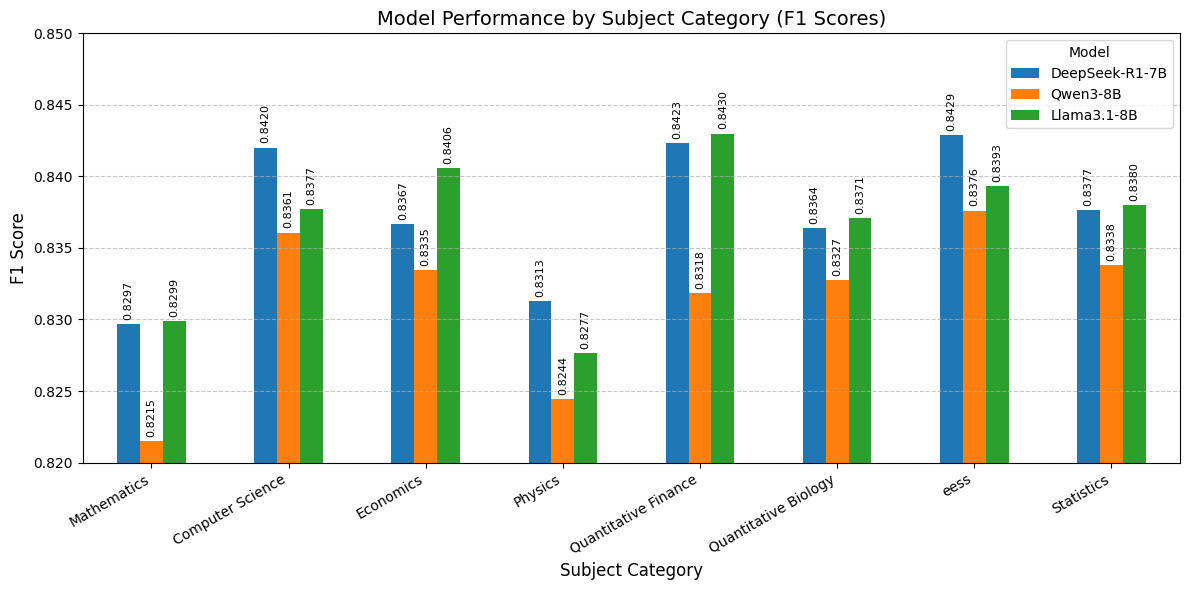

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define F1 scores for each model and subject category
deepseek = {'Mathematics': 0.8296914100646973,
 'Computer Science':
  0.8420159816741943,
 'Economics': 0.8366832137107849,
 'Physics': 0.8312655091285706,
 'Quantitative Finance': 0.8423416018486023,
 'Quantitative Biology': 0.8364019393920898,
 'eess': 0.8428746461868286,
 'Statistics': 0.8376694917678833}

qwen = {'Mathematics':  0.8214947581291199,
 'Computer Science': 0.8360781669616699,
 'Economics': 0.833453893661499,
 'Physics': 0.8244150876998901,
 'Quantitative Finance':  0.8318255543708801,
 'Quantitative Biology':  0.8327333331108093,
 'eess':  0.837612509727478,
 'Statistics':  0.8338162899017334}




llama = {'Mathematics': 0.8299015760421753,
 'Computer Science':  0.8377202153205872,
 'Economics':  0.8406089544296265,
 'Physics':  0.827663004398346,
 'Quantitative Finance': 0.8429911732673645,
 'Quantitative Biology':  0.8370809555053711,
 'eess':  0.8392980098724365,
 'Statistics':  0.8379688858985901}

# Combine into a DataFrame
df = pd.DataFrame({
    'DeepSeek-R1-7B': deepseek,
    'Qwen3-8B': qwen,
    'Llama3.1-8B': llama
}).T

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bar_plot = df.T.plot(kind='bar', ax=ax)

# Add labels and style
plt.title('Model Performance by Subject Category (F1 Scores)', fontsize=14)
plt.xlabel('Subject Category', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.ylim(0.82, 0.85)
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of bars
for container in bar_plot.containers:
    bar_plot.bar_label(container,
        fmt='%.4f',
        fontsize=8,
        padding=3,
        rotation=90,
        label_type='edge')

plt.tight_layout()
plt.show()

# # Save chart as image
# plt.savefig("model_f1_comparison_labeled.png", dpi=300)
# plt.close()

# print("✅ Bar chart with data labels saved as 'model_f1_comparison_labeled.png'")


In [149]:
llam={'precision': 0.8452584147453308,
 'recall': 0.8285602331161499,
 'f1': 0.8366815447807312}

In [3]:
from bert_score import score
from sentence_transformers import SentenceTransformer, util
import pandas as pd

# (Predicted, Reference)
pairs = [
    ("The sixth moment of quadratic Dirichlet L-functions", "The fourth moment of quadratic Dirichlet $L$-Functions II"),
    ("Exploring Axion Dynamics in Inflationary Models", "Analytic results in aligned axion inflation"),
    ("Optimized Reconfigurable Intelligent Surface Design for Enhanced Communication", "Design and Operation Principles of a Wave-Controlled Reconfigurable Intelligent Surface"),
    ("Ensemble Learning for Intraday Electricity Price Forecasting: A CRPS-Based Approach", "From day-ahead to mid and long-term horizons with econometric electricity price forecasting models"),
    ("Two-Dimensional Electron Systems: Properties and Applications", "Quantum Monte Carlo study of the phase diagram of the two-dimensional uniform electron liquid"),
    ("Incorporating Data Dependencies into Model-Based Testing Frameworks for Enhanced Verification", "Software Verification with CPAchecker 3.0: Tutorial and User Guide (Extended Version)"),
    ("Exploring shape-phase transitions in neutron-rich Ba isotopes with enhanced particle-vibration coupling models", "Transitions To Door-way States And Nuclear Responses Against 2-body External Fields"),
    ("Blockchain-Enhanced Energy Management in MIMO-NOMA Networks", "DRL-Based Dynamic Channel Access and SCLAR Maximization for Networks Under Jamming"),
    ("Behavioral Dynamic Programming in Asset Pricing", "Recent Advances on Uniqueness of Competitive Equilibrium"),
    ("Advanced Compression Techniques for 5G Cloud Radio Access Networks", "Revisiting Optimism and Model Complexity in the Wake of Overparameterized Machine Learning")
]

# Extract targets (ground truth) and predictions
predictions = [p[0] for p in pairs]
targets = [p[1] for p in pairs]

# Compute BERTScore
P, R, F1 = score(predictions, targets, lang="en", model_type="roberta-large", verbose=True)
bertscores = F1.tolist()

# Compute cosine similarity
model = SentenceTransformer("all-MiniLM-L6-v2")
target_emb = model.encode(targets, convert_to_tensor=True)
pred_emb = model.encode(predictions, convert_to_tensor=True)
cosine_scores = [util.cos_sim(pred_emb[i], target_emb[i]).item() for i in range(len(pairs))]

# Assign categories (10 total)
categories = [
    "Mathematics", "Physics", "EESS", "Statistics", "Physics",
    "Computer Science", "Physics", "EESS", "Economics", "Statistics"
]

# Create DataFrame
df = pd.DataFrame({
    "Category": categories,
    "Predicted Title": predictions,
    "Reference Title": targets,
    "BERTScore (F1)": bertscores,
    "Cosine Similarity": cosine_scores
})

df


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.87 seconds, 5.34 sentences/sec


Category                                    Predicted Title  \
0       Mathematics  The sixth moment of quadratic Dirichlet L-func...   
1           Physics    Exploring Axion Dynamics in Inflationary Models   
2              EESS  Optimized Reconfigurable Intelligent Surface D...   
3        Statistics  Ensemble Learning for Intraday Electricity Pri...   
4           Physics  Two-Dimensional Electron Systems: Properties a...   
5  Computer Science  Incorporating Data Dependencies into Model-Bas...   
6           Physics  Exploring shape-phase transitions in neutron-r...   
7              EESS  Blockchain-Enhanced Energy Management in MIMO-...   
8         Economics    Behavioral Dynamic Programming in Asset Pricing   
9        Statistics  Advanced Compression Techniques for 5G Cloud R...   

                                     Reference Title  BERTScore (F1)  \
0  The fourth moment of quadratic Dirichlet $L$-F...        0.947834   
1        Analytic results in aligned axion inflation        0.866957   
2  Design and Operation Principles of a Wave-Cont...        0.879273   
3  From day-ahead to mid and long-term horizons w...        0.834223   
4  Quantum Monte Carlo study of the phase diagram...        0.866517   
5  Software Verification with CPAchecker 3.0: Tut...        0.853065   
6  Transitions To Door-way States And Nuclear Res...        0.830512   
7  DRL-Based Dynamic Channel Access and SCLAR Max...        0.865921   
8  Recent Advances on Uniqueness of Competitive E...        0.875613   
9  Revisiting Optimism and Model Complexity in th...        0.841246   

   Cosine Similarity  
0           0.916460  
1           0.822459  
2           0.737635  
3           0.639014  
4           0.517687  
5           0.442728  
6           0.355337  
7           0.274583  
8           0.254176  
9          -0.008703

In [55]:
%pip install git+https://github.com/neulab/BARTScore.git


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Cloning https://github.com/neulab/BARTScore.git to /private/var/folders/zm/f6t7fybj7h78zygzyv2r94fr0000gn/T/pip-req-build-2jo14qqm
  Running command git clone --filter=blob:none --quiet https://github.com/neulab/BARTScore.git /private/var/folders/zm/f6t7fybj7h78zygzyv2r94fr0000gn/T/pip-req-build-2jo14qqm
  Resolved https://github.com/neulab/BARTScore.git to commit 248f511cb34ae3753fc81f7d7a945de5bfe33458
ERROR: git+https://github.com/neulab/BARTScore.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Note: you may need to restart the kernel to use updated packages.


In [57]:
%pip install bart_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement bart_score (from versions: none)
ERROR: No matching distribution found for bart_score
Note: you may need to restart the kernel to use updated packages.


In [56]:
from bart_score import BARTScorer

bart_scorer = BARTScorer(device='cuda' if torch.cuda.is_available() else 'cpu',
                         checkpoint='facebook/bart-large-cnn')

score = bart_scorer.score(
    ["An Enhanced Deep Learning Framework for Predictive Analytics"],
    ["On the prime ends extension of unclosed inverse mappings"]
)
print("BARTScore:", score)


ModuleNotFoundError: No module named 'bart_score'